## Google Driveのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## データセットの準備

In [ ]:
# kaggle ライブラリのインストール
!pip install kaggle

# 一時フォルダに .kaggleフォルダを作成
!mkdir ~/.kaggle

# MyDrive の kaggle.json を一時フォルダ内の .kaggleフォルダにコピー
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

# アクセス権限の設定
!chmod 600 ~/.kaggle/kaggle.json

!mkdir ~/.kaggle

# zipファイルのダウンロード
!kaggle datasets download -d ashaheedq/video-games-sales-2019 -p /content/drive/MyDrive/kaggle

# 解凍
!unzip /content/drive/MyDrive/kaggle/video-games-sales-2019.zip -d /content/drive/MyDrive/kaggle

!rm /content/drive/MyDrive/kaggle/video-games-sales-2019.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/3.98M [00:00<?, ?B/s]
100% 3.98M/3.98M [00:00<00:00, 64.5MB/s]
Archive:  /content/drive/MyDrive/kaggle/video-games-sales-2019.zip
replace /content/drive/MyDrive/kaggle/vgsales-12-4-2019-short.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: None


## データの読込

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/kaggle/vgsales-12-4-2019.csv")
df.head(3)

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,User_Score,Total_Shipped,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,NaN,82.86,NaN,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,NaN,40.24,NaN,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,9.1,37.14,NaN,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg


### Stacking

In [ ]:
!pip install category_encoders
!pip install optuna
!pip install pandas
!pip install japanize-matplotlib
!pip install catboost

     |████████████████████████████████| 82 kB 386 kB/s 
     |████████████████████████████████| 308 kB 5.2 MB/s 
     |████████████████████████████████| 80 kB 9.5 MB/s 
     |████████████████████████████████| 209 kB 57.0 MB/s 
     |████████████████████████████████| 75 kB 4.2 MB/s 
     |████████████████████████████████| 49 kB 4.7 MB/s 
     |████████████████████████████████| 112 kB 76.1 MB/s 
     |████████████████████████████████| 149 kB 75.0 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=f9745404d98e5417ca9a681e0b26ce14869b1fb95ac7ca1c7768962f62ff3eae
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
     |████████████████████████████████| 4.1 MB 5.1 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120274 sha256=094ff6523df3cd0602de086bdddb47e99a5e275bba35b2c771535fe52c8a5ea0
  Stored in direct

In [ ]:
import os
import time
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from natsort import natsorted 

import lightgbm as lgb
import optuna.integration.lightgbm as opt_lgb
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold

import warnings
warnings.simplefilter('ignore')

In [ ]:
# シード値の固定
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    df.dropna(subset=["Global_Sales"]).drop(["Global_Sales",  "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"], axis=1), 
                                                    df.dropna(subset=["Global_Sales"])["Global_Sales"],  
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    random_state=SEED
                                                    ) 

In [ ]:
### 欠損値補完
X_train_ff = X_train.fillna(method='ffill')
X_test_ff = X_test.fillna(method='ffill')

#### カテゴリーエンコーディング

# ユニーク数に応じてカラムを分割する
category_unique_num = X_train_ff.select_dtypes(include="object").nunique()

few_kinds_category_columns = category_unique_num[category_unique_num < 10].index
many_kinds_category_columns = category_unique_num[category_unique_num >= 10].index


# カテゴリーのエンコーディング法則を指定する
ordinal_all_cols_mapping_ce = []

for i, column in enumerate(many_kinds_category_columns):
    ordinal_one_cols_mapping = {}
    ordinal_one_cols_mapping_breakdown = {}
    for j, category in enumerate(natsorted(X_train_ff[column].unique())):
        ordinal_one_cols_mapping_breakdown[category] = j

    ordinal_one_cols_mapping["col"] = column
    ordinal_one_cols_mapping["mapping"] = ordinal_one_cols_mapping_breakdown
    ordinal_all_cols_mapping_ce.append(ordinal_one_cols_mapping)


# エンコーディング設定
ode = ce.OrdinalEncoder(
    mapping = ordinal_all_cols_mapping_ce,
    cols = many_kinds_category_columns
)

ohe = ce.OneHotEncoder(
    use_cat_names=True,
    cols = few_kinds_category_columns
)

# 元データをコピー
X_train_ce = X_train_ff.copy()
X_test_ce = X_test_ff.copy()

# OneHotEncoder
X_train_ce = ohe.fit_transform(X_train_ce)
X_test_ce = ohe.transform(X_test_ce)

# OrdinalHotEncoder
X_train_ce = ode.fit_transform(X_train_ce)
X_test_ce = ode.transform(X_test_ce)

# 正規化
sc = StandardScaler()
X_train_ce = pd.DataFrame(
                            sc.fit_transform(X_train_ce),
                            columns=X_train_ce.columns
                            )

X_test_ce = pd.DataFrame(
                            sc.transform(X_test_ce),
                            columns=X_test_ce.columns
                            )

In [ ]:
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# 欠損の削除
X_train_dropna = X_train_ce.dropna(how="all", axis=1)
X_train_dropna = X_train_dropna.dropna(how="any", axis=0)

X_test_dropna = X_test_ce.dropna(how="all", axis=1)
X_test_dropna = X_test_dropna.dropna(how="any", axis=0)


# X の欠損行を削除したので、y もそれに合わせる
y_train = y_train.reset_index(drop=True)
y_train_dropna = y_train[y_train.index.isin(X_train_dropna.index)]

y_test = y_test.reset_index(drop=True)
y_test_dropna = y_test[y_test.index.isin(X_test_dropna.index)]

[I 2021-12-14 10:59:39,140] A new study created in memory with name: no-name-2ccf542d-06f6-4966-b975-c32826053a5c


Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 10:59:39,503] Trial 0 finished with value: 0.3587247613360196 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.3587247613360196.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12183	Test's rmse: 0.358725
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 10:59:39,929] Trial 1 finished with value: 0.3711351653613576 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.3587247613360196.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.110668	Test's rmse: 0.371135
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 10:59:40,320] Trial 2 finished with value: 0.35951674463088273 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.3587247613360196.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119178	Test's rmse: 0.359517
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 10:59:40,763] Trial 3 finished with value: 0.34548637147095995 and parameters: {'feature_fraction': 1.0}. Best is trial 3 with value: 0.34548637147095995.


Early stopping, best iteration is:
[34]	Train's rmse: 0.153648	Test's rmse: 0.345486
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 10:59:41,261] Trial 4 finished with value: 0.347242655144157 and parameters: {'feature_fraction': 0.8}. Best is trial 3 with value: 0.34548637147095995.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.109017	Test's rmse: 0.347243
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 10:59:41,767] Trial 5 finished with value: 0.3435388009864898 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 5 with value: 0.3435388009864898.


Early stopping, best iteration is:
[48]	Train's rmse: 0.144723	Test's rmse: 0.343539
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 10:59:42,224] Trial 6 finished with value: 0.34915433825457787 and parameters: {'feature_fraction': 0.7}. Best is trial 5 with value: 0.3435388009864898.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.111333	Test's rmse: 0.349154
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 10:59:44,179] Trial 7 finished with value: 0.345164673435752 and parameters: {'num_leaves': 231}. Best is trial 7 with value: 0.345164673435752.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.123623	Test's rmse: 0.345165
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 10:59:46,287] Trial 8 finished with value: 0.34310808492372175 and parameters: {'num_leaves': 255}. Best is trial 8 with value: 0.34310808492372175.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.123931	Test's rmse: 0.343108
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 10:59:46,909] Trial 9 finished with value: 0.34561132581267573 and parameters: {'num_leaves': 41}. Best is trial 8 with value: 0.34310808492372175.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.122988	Test's rmse: 0.345611
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 10:59:47,903] Trial 10 finished with value: 0.34209590635766196 and parameters: {'num_leaves': 90}. Best is trial 10 with value: 0.34209590635766196.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.126943	Test's rmse: 0.342096
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 10:59:49,382] Trial 11 finished with value: 0.3419585938348256 and parameters: {'num_leaves': 159}. Best is trial 11 with value: 0.3419585938348256.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.126608	Test's rmse: 0.341959
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 10:59:51,076] Trial 12 finished with value: 0.3422569215272443 and parameters: {'num_leaves': 192}. Best is trial 11 with value: 0.3419585938348256.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.125374	Test's rmse: 0.342257
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 10:59:52,784] Trial 13 finished with value: 0.34286504507607846 and parameters: {'num_leaves': 195}. Best is trial 11 with value: 0.3419585938348256.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.125708	Test's rmse: 0.342865
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 10:59:53,633] Trial 14 finished with value: 0.34129587326724287 and parameters: {'num_leaves': 73}. Best is trial 14 with value: 0.34129587326724287.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.126383	Test's rmse: 0.341296
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 10:59:55,716] Trial 15 finished with value: 0.34425538384172283 and parameters: {'num_leaves': 253}. Best is trial 14 with value: 0.34129587326724287.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.126862	Test's rmse: 0.344255
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 10:59:56,770] Trial 16 finished with value: 0.3419195792732364 and parameters: {'num_leaves': 97}. Best is trial 14 with value: 0.34129587326724287.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127668	Test's rmse: 0.34192
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 10:59:57,166] Trial 17 finished with value: 0.34262185800760153 and parameters: {'num_leaves': 20}. Best is trial 14 with value: 0.34129587326724287.


Early stopping, best iteration is:
[42]	Train's rmse: 0.150693	Test's rmse: 0.342622
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 10:59:58,184] Trial 18 finished with value: 0.34332813460137884 and parameters: {'num_leaves': 92}. Best is trial 14 with value: 0.34129587326724287.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.125233	Test's rmse: 0.343328
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 10:59:59,132] Trial 19 finished with value: 0.34321903764053296 and parameters: {'num_leaves': 85}. Best is trial 14 with value: 0.34129587326724287.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12524	Test's rmse: 0.343219
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:00,399] Trial 20 finished with value: 0.3436795614482001 and parameters: {'num_leaves': 127}. Best is trial 14 with value: 0.34129587326724287.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.125557	Test's rmse: 0.34368
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:01,152] Trial 21 finished with value: 0.34820617630713147 and parameters: {'num_leaves': 56}. Best is trial 14 with value: 0.34129587326724287.
[I 2021-12-14 11:00:01,307] Trial 22 finished with value: 0.33212833202190495 and parameters: {'num_leaves': 2}. Best is trial 22 with value: 0.33212833202190495.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.122305	Test's rmse: 0.348206
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.184244	Test's rmse: 0.332128


[I 2021-12-14 11:00:01,529] Trial 23 finished with value: 0.33541830081071955 and parameters: {'num_leaves': 5}. Best is trial 22 with value: 0.33212833202190495.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136588	Test's rmse: 0.335418


[I 2021-12-14 11:00:01,796] Trial 24 finished with value: 0.34108356653216954 and parameters: {'num_leaves': 9}. Best is trial 22 with value: 0.33212833202190495.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[48]	Train's rmse: 0.142808	Test's rmse: 0.341084
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:02,348] Trial 25 finished with value: 0.34249478337680533 and parameters: {'num_leaves': 33}. Best is trial 22 with value: 0.33212833202190495.
[I 2021-12-14 11:00:02,539] Trial 26 finished with value: 0.3297415931189004 and parameters: {'num_leaves': 3}. Best is trial 26 with value: 0.3297415931189004.


Early stopping, best iteration is:
[49]	Train's rmse: 0.143685	Test's rmse: 0.342495
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174149	Test's rmse: 0.329742


[I 2021-12-14 11:00:02,752] Trial 27 finished with value: 0.33438998027274197 and parameters: {'bagging_fraction': 0.959527830606524, 'bagging_freq': 3}. Best is trial 27 with value: 0.33438998027274197.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168811	Test's rmse: 0.33439


[I 2021-12-14 11:00:02,949] Trial 28 finished with value: 0.3265410904979936 and parameters: {'bagging_fraction': 0.7625874918520994, 'bagging_freq': 6}. Best is trial 28 with value: 0.3265410904979936.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174986	Test's rmse: 0.326541
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:03,141] Trial 29 finished with value: 0.32892478704643324 and parameters: {'bagging_fraction': 0.6001440729806908, 'bagging_freq': 3}. Best is trial 28 with value: 0.3265410904979936.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.171413	Test's rmse: 0.328925
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:03,349] Trial 30 finished with value: 0.3328211559935589 and parameters: {'bagging_fraction': 0.865687287629858, 'bagging_freq': 2}. Best is trial 28 with value: 0.3265410904979936.
[I 2021-12-14 11:00:03,538] Trial 31 finished with value: 0.33306508428389514 and parameters: {'bagging_fraction': 0.7204249070511699, 'bagging_freq': 7}. Best is trial 28 with value: 0.3265410904979936.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.169925	Test's rmse: 0.332821
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.169746	Test's rmse: 0.333065


[I 2021-12-14 11:00:03,740] Trial 32 finished with value: 0.3277097228664883 and parameters: {'bagging_fraction': 0.8703395240477553, 'bagging_freq': 6}. Best is trial 28 with value: 0.3265410904979936.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.175227	Test's rmse: 0.32771


[I 2021-12-14 11:00:03,927] Trial 33 finished with value: 0.33341581056814734 and parameters: {'bagging_fraction': 0.6087144771771188, 'bagging_freq': 5}. Best is trial 28 with value: 0.3265410904979936.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.175247	Test's rmse: 0.333416
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:04,126] Trial 34 finished with value: 0.3287599051091752 and parameters: {'bagging_fraction': 0.5276839663054722, 'bagging_freq': 6}. Best is trial 28 with value: 0.3265410904979936.
[I 2021-12-14 11:00:04,321] Trial 35 finished with value: 0.3310567023655454 and parameters: {'bagging_fraction': 0.7091804327843617, 'bagging_freq': 4}. Best is trial 28 with value: 0.3265410904979936.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174051	Test's rmse: 0.32876
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.175716	Test's rmse: 0.331057


[I 2021-12-14 11:00:04,504] Trial 36 finished with value: 0.32931145354559527 and parameters: {'bagging_fraction': 0.6203587039539284, 'bagging_freq': 4}. Best is trial 28 with value: 0.3265410904979936.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.175239	Test's rmse: 0.329311
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:04,705] Trial 37 finished with value: 0.3298350696841916 and parameters: {'feature_fraction': 0.852}. Best is trial 37 with value: 0.3298350696841916.
[I 2021-12-14 11:00:04,895] Trial 38 finished with value: 0.3265410904979936 and parameters: {'feature_fraction': 0.9159999999999999}. Best is trial 38 with value: 0.3265410904979936.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.175885	Test's rmse: 0.329835
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174986	Test's rmse: 0.326541


[I 2021-12-14 11:00:05,098] Trial 39 finished with value: 0.3265410904979936 and parameters: {'feature_fraction': 0.948}. Best is trial 38 with value: 0.3265410904979936.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174986	Test's rmse: 0.326541
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:05,288] Trial 40 finished with value: 0.3255705220210477 and parameters: {'feature_fraction': 0.82}. Best is trial 40 with value: 0.3255705220210477.
[I 2021-12-14 11:00:05,477] Trial 41 finished with value: 0.3287531132365613 and parameters: {'feature_fraction': 0.9799999999999999}. Best is trial 40 with value: 0.3255705220210477.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.175708	Test's rmse: 0.325571
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174066	Test's rmse: 0.328753


[I 2021-12-14 11:00:05,668] Trial 42 finished with value: 0.3298350696841916 and parameters: {'feature_fraction': 0.8839999999999999}. Best is trial 40 with value: 0.3255705220210477.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.175885	Test's rmse: 0.329835
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:05,862] Trial 43 finished with value: 0.32557055971617305 and parameters: {'lambda_l1': 6.883596059862663e-05, 'lambda_l2': 2.5855950299006472e-08}. Best is trial 43 with value: 0.32557055971617305.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.175708	Test's rmse: 0.325571
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:06,073] Trial 44 finished with value: 0.3255705249107235 and parameters: {'lambda_l1': 5.707667342339108e-07, 'lambda_l2': 1.98905953908926e-05}. Best is trial 44 with value: 0.3255705249107235.
[I 2021-12-14 11:00:06,261] Trial 45 finished with value: 0.32557119296475595 and parameters: {'lambda_l1': 0.0007550094114354345, 'lambda_l2': 0.0019728377242883553}. Best is trial 44 with value: 0.3255705249107235.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.175708	Test's rmse: 0.325571
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.175708	Test's rmse: 0.325571


[I 2021-12-14 11:00:06,453] Trial 46 finished with value: 0.32558619041895626 and parameters: {'lambda_l1': 0.028532583778928318, 'lambda_l2': 0.00027032801060921583}. Best is trial 44 with value: 0.3255705249107235.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.175719	Test's rmse: 0.325586
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:06,647] Trial 47 finished with value: 0.332283614753281 and parameters: {'lambda_l1': 0.011714190463353192, 'lambda_l2': 0.7829708184828689}. Best is trial 44 with value: 0.3255705249107235.
[I 2021-12-14 11:00:06,834] Trial 48 finished with value: 0.3267339627932038 and parameters: {'lambda_l1': 0.0003410671573904537, 'lambda_l2': 0.00835943561824682}. Best is trial 44 with value: 0.3255705249107235.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.176796	Test's rmse: 0.332284
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.175623	Test's rmse: 0.326734


[I 2021-12-14 11:00:07,030] Trial 49 finished with value: 0.32557448336728295 and parameters: {'lambda_l1': 0.007227039604624107, 'lambda_l2': 2.975251028045442e-05}. Best is trial 44 with value: 0.3255705249107235.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.17571	Test's rmse: 0.325574
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:07,230] Trial 50 finished with value: 0.3314310033503378 and parameters: {'lambda_l1': 3.3774991716076834, 'lambda_l2': 9.529199235886427e-06}. Best is trial 44 with value: 0.3255705249107235.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.177784	Test's rmse: 0.331431
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.175632	Test's rmse: 0.326744


[I 2021-12-14 11:00:07,426] Trial 51 finished with value: 0.3267441423503674 and parameters: {'lambda_l1': 0.02111935666658555, 'lambda_l2': 0.008923749882858704}. Best is trial 44 with value: 0.3255705249107235.
[I 2021-12-14 11:00:07,618] Trial 52 finished with value: 0.32924364746045515 and parameters: {'lambda_l1': 1.5822861992449504e-06, 'lambda_l2': 0.162456367434217}. Best is trial 44 with value: 0.3255705249107235.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.17512	Test's rmse: 0.329244
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:07,822] Trial 53 finished with value: 0.3255705220595355 and parameters: {'lambda_l1': 1.0121539507692063e-08, 'lambda_l2': 1.6392463635936565e-07}. Best is trial 53 with value: 0.3255705220595355.
[I 2021-12-14 11:00:08,013] Trial 54 finished with value: 0.325570522041175 and parameters: {'lambda_l1': 1.124159976707757e-08, 'lambda_l2': 8.43194962719407e-08}. Best is trial 54 with value: 0.325570522041175.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.175708	Test's rmse: 0.325571
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.175708	Test's rmse: 0.325571


[I 2021-12-14 11:00:08,225] Trial 55 finished with value: 0.3255705220243514 and parameters: {'lambda_l1': 1.33758379528331e-08, 'lambda_l2': 1.1350226984803164e-08}. Best is trial 55 with value: 0.3255705220243514.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.175708	Test's rmse: 0.325571
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:08,419] Trial 56 finished with value: 0.3255705221201721 and parameters: {'lambda_l1': 1.4105656820457113e-08, 'lambda_l2': 4.316830614168529e-07}. Best is trial 55 with value: 0.3255705220243514.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.175708	Test's rmse: 0.325571
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.175708	Test's rmse: 0.325571

[I 2021-12-14 11:00:08,624] Trial 57 finished with value: 0.32557052225796146 and parameters: {'lambda_l1': 3.9787787748000207e-07, 'lambda_l2': 1.1950723977665192e-08}. Best is trial 55 with value: 0.3255705220243514.



Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.175708	Test's rmse: 0.325571


[I 2021-12-14 11:00:08,818] Trial 58 finished with value: 0.32557052558965377 and parameters: {'lambda_l1': 6.166305312664081e-06, 'lambda_l2': 9.224913788938908e-07}. Best is trial 55 with value: 0.3255705220243514.
[I 2021-12-14 11:00:09,012] Trial 59 finished with value: 0.3255705220954055 and parameters: {'lambda_l1': 8.725903736922738e-08, 'lambda_l2': 9.457252905712227e-08}. Best is trial 55 with value: 0.3255705220243514.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.175708	Test's rmse: 0.325571
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:09,218] Trial 60 finished with value: 0.3255705326703504 and parameters: {'lambda_l1': 1.8603543890713145e-05, 'lambda_l2': 3.712478528258696e-06}. Best is trial 55 with value: 0.3255705220243514.
[I 2021-12-14 11:00:09,415] Trial 61 finished with value: 0.3255705221185135 and parameters: {'lambda_l1': 1.48876664113532e-07, 'lambda_l2': 2.936402572489528e-08}. Best is trial 55 with value: 0.3255705220243514.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.175708	Test's rmse: 0.325571
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.175708	Test's rmse: 0.325571


[I 2021-12-14 11:00:09,615] Trial 62 finished with value: 0.33506827321020655 and parameters: {'lambda_l1': 6.475547392453957, 'lambda_l2': 9.504273554706192}. Best is trial 55 with value: 0.3255705220243514.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.181309	Test's rmse: 0.335068
Training until validation scores don't improve for 50 rounds.

[I 2021-12-14 11:00:09,810] Trial 63 finished with value: 0.41731255305379844 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.41731255305379844.



Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.270007	Test's rmse: 0.417313
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:10,008] Trial 64 finished with value: 0.3270719819338346 and parameters: {'min_child_samples': 10}. Best is trial 64 with value: 0.3270719819338346.
[I 2021-12-14 11:00:10,201] Trial 65 finished with value: 0.3833471728492513 and parameters: {'min_child_samples': 50}. Best is trial 64 with value: 0.3270719819338346.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.161185	Test's rmse: 0.327072
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.235348	Test's rmse: 0.383347


[I 2021-12-14 11:00:10,387] Trial 66 finished with value: 0.33093177640916516 and parameters: {'min_child_samples': 5}. Best is trial 64 with value: 0.3270719819338346.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.158561	Test's rmse: 0.330932
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:10,576] Trial 67 finished with value: 0.33316626870796356 and parameters: {'min_child_samples': 25}. Best is trial 64 with value: 0.3270719819338346.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.177636	Test's rmse: 0.333166


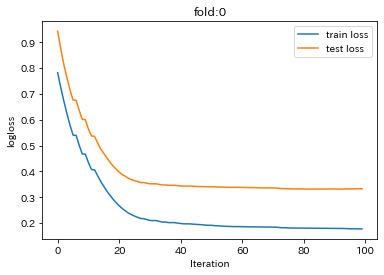

[I 2021-12-14 11:00:10,780] A new study created in memory with name: no-name-81599aeb-ed95-43a8-93c7-526131988a24


Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:11,236] Trial 0 finished with value: 0.1120569964401173 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.1120569964401173.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131906	Test's rmse: 0.112057
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:11,721] Trial 1 finished with value: 0.10834965404569909 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 0.10834965404569909.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130029	Test's rmse: 0.10835
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:12,137] Trial 2 finished with value: 0.12344140666902119 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.10834965404569909.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131736	Test's rmse: 0.123441
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:12,521] Trial 3 finished with value: 0.14563888242682213 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 0.10834965404569909.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137295	Test's rmse: 0.145639
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:13,060] Trial 4 finished with value: 0.11256295527908217 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 0.10834965404569909.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15304	Test's rmse: 0.112563
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:13,585] Trial 5 finished with value: 0.11178605491776616 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 0.10834965404569909.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147057	Test's rmse: 0.111786
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:13,934] Trial 6 finished with value: 0.13870240145354 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 0.10834965404569909.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137253	Test's rmse: 0.138702
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:14,644] Trial 7 finished with value: 0.10749979406136366 and parameters: {'num_leaves': 57}. Best is trial 7 with value: 0.10749979406136366.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13207	Test's rmse: 0.1075
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:14,953] Trial 8 finished with value: 0.10467924186520333 and parameters: {'num_leaves': 12}. Best is trial 8 with value: 0.10467924186520333.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136148	Test's rmse: 0.104679
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:15,515] Trial 9 finished with value: 0.1060131325862426 and parameters: {'num_leaves': 39}. Best is trial 8 with value: 0.10467924186520333.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131967	Test's rmse: 0.106013
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:16,111] Trial 10 finished with value: 0.10239900242520011 and parameters: {'num_leaves': 45}. Best is trial 10 with value: 0.10239900242520011.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133032	Test's rmse: 0.102399
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:17,845] Trial 11 finished with value: 0.11642464691557643 and parameters: {'num_leaves': 222}. Best is trial 10 with value: 0.10239900242520011.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133095	Test's rmse: 0.116425
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:19,256] Trial 12 finished with value: 0.11504884214721363 and parameters: {'num_leaves': 161}. Best is trial 10 with value: 0.10239900242520011.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135628	Test's rmse: 0.115049
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:20,192] Trial 13 finished with value: 0.10956880000082544 and parameters: {'num_leaves': 91}. Best is trial 10 with value: 0.10239900242520011.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134908	Test's rmse: 0.109569
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:20,670] Trial 14 finished with value: 0.1025897801019396 and parameters: {'num_leaves': 30}. Best is trial 10 with value: 0.10239900242520011.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132575	Test's rmse: 0.10259
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:21,814] Trial 15 finished with value: 0.11247953865750078 and parameters: {'num_leaves': 125}. Best is trial 10 with value: 0.10239900242520011.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131874	Test's rmse: 0.11248
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:22,823] Trial 16 finished with value: 0.1136916955004557 and parameters: {'num_leaves': 103}. Best is trial 10 with value: 0.10239900242520011.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137555	Test's rmse: 0.113692
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:24,735] Trial 17 finished with value: 0.11707817099530335 and parameters: {'num_leaves': 254}. Best is trial 10 with value: 0.10239900242520011.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133411	Test's rmse: 0.117078


[I 2021-12-14 11:00:25,010] Trial 18 finished with value: 0.11082807016139735 and parameters: {'num_leaves': 10}. Best is trial 10 with value: 0.10239900242520011.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134336	Test's rmse: 0.110828
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:25,783] Trial 19 finished with value: 0.109502676971808 and parameters: {'num_leaves': 68}. Best is trial 10 with value: 0.10239900242520011.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132353	Test's rmse: 0.109503
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:27,238] Trial 20 finished with value: 0.11539963530018137 and parameters: {'num_leaves': 176}. Best is trial 10 with value: 0.10239900242520011.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130777	Test's rmse: 0.1154
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:27,850] Trial 21 finished with value: 0.10449495581354348 and parameters: {'num_leaves': 47}. Best is trial 10 with value: 0.10239900242520011.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131264	Test's rmse: 0.104495
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:28,108] Trial 22 finished with value: 0.11377895254751762 and parameters: {'num_leaves': 9}. Best is trial 10 with value: 0.10239900242520011.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135152	Test's rmse: 0.113779
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:29,013] Trial 23 finished with value: 0.10627406656326316 and parameters: {'num_leaves': 86}. Best is trial 10 with value: 0.10239900242520011.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133148	Test's rmse: 0.106274
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:30,213] Trial 24 finished with value: 0.11552064170062165 and parameters: {'num_leaves': 128}. Best is trial 10 with value: 0.10239900242520011.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134996	Test's rmse: 0.115521
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:30,774] Trial 25 finished with value: 0.10376485494180666 and parameters: {'num_leaves': 38}. Best is trial 10 with value: 0.10239900242520011.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13259	Test's rmse: 0.103765
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:32,158] Trial 26 finished with value: 0.11537602938664267 and parameters: {'num_leaves': 158}. Best is trial 10 with value: 0.10239900242520011.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137074	Test's rmse: 0.115376
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:32,771] Trial 27 finished with value: 0.11740495203007326 and parameters: {'bagging_fraction': 0.50997301304924, 'bagging_freq': 1}. Best is trial 27 with value: 0.11740495203007326.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.188228	Test's rmse: 0.117405
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:33,448] Trial 28 finished with value: 0.11984112626613194 and parameters: {'bagging_fraction': 0.8579069390004377, 'bagging_freq': 6}. Best is trial 27 with value: 0.11740495203007326.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.164809	Test's rmse: 0.119841
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:34,066] Trial 29 finished with value: 0.10120361752967148 and parameters: {'bagging_fraction': 0.9886608649666221, 'bagging_freq': 1}. Best is trial 29 with value: 0.10120361752967148.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131085	Test's rmse: 0.101204
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:34,734] Trial 30 finished with value: 0.11242503518435672 and parameters: {'bagging_fraction': 0.8272797230529718, 'bagging_freq': 7}. Best is trial 29 with value: 0.10120361752967148.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.170775	Test's rmse: 0.112425
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:35,404] Trial 31 finished with value: 0.11841068783150219 and parameters: {'bagging_fraction': 0.763581576888949, 'bagging_freq': 6}. Best is trial 29 with value: 0.10120361752967148.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.177692	Test's rmse: 0.118411
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:36,088] Trial 32 finished with value: 0.11420208868306618 and parameters: {'bagging_fraction': 0.8822931749844816, 'bagging_freq': 3}. Best is trial 29 with value: 0.10120361752967148.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.159356	Test's rmse: 0.114202
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:36,739] Trial 33 finished with value: 0.11556666085133042 and parameters: {'bagging_fraction': 0.5887073510525905, 'bagging_freq': 7}. Best is trial 29 with value: 0.10120361752967148.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.181956	Test's rmse: 0.115567
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:37,371] Trial 34 finished with value: 0.11821083339955193 and parameters: {'bagging_fraction': 0.4358105918182729, 'bagging_freq': 7}. Best is trial 29 with value: 0.10120361752967148.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.191141	Test's rmse: 0.118211
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:38,050] Trial 35 finished with value: 0.11229140780289154 and parameters: {'bagging_fraction': 0.8863515114971008, 'bagging_freq': 5}. Best is trial 29 with value: 0.10120361752967148.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15482	Test's rmse: 0.112291
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:38,684] Trial 36 finished with value: 0.1301022625092973 and parameters: {'bagging_fraction': 0.47773135903634933, 'bagging_freq': 7}. Best is trial 29 with value: 0.10120361752967148.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.189278	Test's rmse: 0.130102
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:39,285] Trial 37 finished with value: 0.10613860072823889 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 37 with value: 0.10613860072823889.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128162	Test's rmse: 0.106139
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:39,855] Trial 38 finished with value: 0.1144396863110791 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 37 with value: 0.10613860072823889.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129718	Test's rmse: 0.11444
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:40,452] Trial 39 finished with value: 0.10120361752967148 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 39 with value: 0.10120361752967148.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131085	Test's rmse: 0.101204
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:41,060] Trial 40 finished with value: 0.10120361752967148 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 39 with value: 0.10120361752967148.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131085	Test's rmse: 0.101204
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:41,693] Trial 41 finished with value: 0.10502791281878249 and parameters: {'feature_fraction': 0.88}. Best is trial 39 with value: 0.10120361752967148.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133907	Test's rmse: 0.105028
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:42,288] Trial 42 finished with value: 0.10613860072823889 and parameters: {'feature_fraction': 0.784}. Best is trial 39 with value: 0.10120361752967148.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128162	Test's rmse: 0.106139
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:42,839] Trial 43 finished with value: 0.10459851260599073 and parameters: {'lambda_l1': 0.8633156693734956, 'lambda_l2': 0.06135740206833867}. Best is trial 43 with value: 0.10459851260599073.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130885	Test's rmse: 0.104599
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:43,451] Trial 44 finished with value: 0.1036406701879034 and parameters: {'lambda_l1': 1.225964989782541e-07, 'lambda_l2': 0.004609423968616891}. Best is trial 44 with value: 0.1036406701879034.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132679	Test's rmse: 0.103641
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:44,073] Trial 45 finished with value: 0.10243901490304616 and parameters: {'lambda_l1': 0.015745846383851375, 'lambda_l2': 0.0030122893370128877}. Best is trial 45 with value: 0.10243901490304616.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133189	Test's rmse: 0.102439
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:44,654] Trial 46 finished with value: 0.11418929593076887 and parameters: {'lambda_l1': 0.045339048992364794, 'lambda_l2': 3.929303819234355}. Best is trial 45 with value: 0.10243901490304616.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139427	Test's rmse: 0.114189
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:45,281] Trial 47 finished with value: 0.10219995941897993 and parameters: {'lambda_l1': 1.2695596791163623e-05, 'lambda_l2': 0.00012441936953830392}. Best is trial 47 with value: 0.10219995941897993.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129991	Test's rmse: 0.1022
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:45,920] Trial 48 finished with value: 0.10102201199970555 and parameters: {'lambda_l1': 2.3074722087018815e-06, 'lambda_l2': 1.8854603862661595e-07}. Best is trial 48 with value: 0.10102201199970555.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131642	Test's rmse: 0.101022
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:46,536] Trial 49 finished with value: 0.10782253426532676 and parameters: {'lambda_l1': 4.673122153793461e-07, 'lambda_l2': 0.020641821391102322}. Best is trial 48 with value: 0.10102201199970555.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133786	Test's rmse: 0.107823
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:47,159] Trial 50 finished with value: 0.10102201172429456 and parameters: {'lambda_l1': 1.9524315497814376e-06, 'lambda_l2': 1.0936346775619673e-07}. Best is trial 50 with value: 0.10102201172429456.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131642	Test's rmse: 0.101022
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:47,778] Trial 51 finished with value: 0.1064704389389843 and parameters: {'lambda_l1': 7.231354486191262e-06, 'lambda_l2': 0.01566939341917563}. Best is trial 50 with value: 0.10102201172429456.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132045	Test's rmse: 0.10647
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:48,381] Trial 52 finished with value: 0.10438424059540356 and parameters: {'lambda_l1': 0.04190581014225153, 'lambda_l2': 2.873388479560053e-06}. Best is trial 50 with value: 0.10102201172429456.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128688	Test's rmse: 0.104384
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:49,003] Trial 53 finished with value: 0.1024389557772626 and parameters: {'lambda_l1': 0.000715751402967932, 'lambda_l2': 3.4390310509757965e-08}. Best is trial 50 with value: 0.10102201172429456.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130989	Test's rmse: 0.102439
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:49,602] Trial 54 finished with value: 0.10120361756291824 and parameters: {'lambda_l1': 1.9713966401172932e-08, 'lambda_l2': 1.209429590100546e-08}. Best is trial 50 with value: 0.10102201172429456.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131085	Test's rmse: 0.101204
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:50,214] Trial 55 finished with value: 0.10102202188713184 and parameters: {'lambda_l1': 1.5169756795713016e-05, 'lambda_l2': 1.0244129403118579e-06}. Best is trial 50 with value: 0.10102201172429456.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131642	Test's rmse: 0.101022
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:50,817] Trial 56 finished with value: 0.10120361807262734 and parameters: {'lambda_l1': 8.754761087470014e-07, 'lambda_l2': 1.624913865716877e-06}. Best is trial 50 with value: 0.10102201172429456.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131085	Test's rmse: 0.101204
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:51,441] Trial 57 finished with value: 0.10130033569358206 and parameters: {'lambda_l1': 0.0002077367731071963, 'lambda_l2': 7.187795105819439e-05}. Best is trial 50 with value: 0.10102201172429456.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132413	Test's rmse: 0.1013
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:52,063] Trial 58 finished with value: 0.10120361765936897 and parameters: {'lambda_l1': 1.135403178398509e-08, 'lambda_l2': 1.6580994332638335e-07}. Best is trial 50 with value: 0.10102201172429456.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131085	Test's rmse: 0.101204
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:52,669] Trial 59 finished with value: 0.10067613104097398 and parameters: {'lambda_l1': 0.0001315908632227867, 'lambda_l2': 1.00621801707644e-05}. Best is trial 59 with value: 0.10067613104097398.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13116	Test's rmse: 0.100676
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:53,301] Trial 60 finished with value: 0.10130036363451722 and parameters: {'lambda_l1': 0.0002244403472680683, 'lambda_l2': 9.69576248039394e-06}. Best is trial 59 with value: 0.10067613104097398.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132413	Test's rmse: 0.1013
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:53,921] Trial 61 finished with value: 0.10451663757895666 and parameters: {'lambda_l1': 0.0023958800757911975, 'lambda_l2': 3.808122085419346e-05}. Best is trial 59 with value: 0.10067613104097398.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133954	Test's rmse: 0.104517
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:54,533] Trial 62 finished with value: 0.10220101069401409 and parameters: {'lambda_l1': 6.170974733958616e-05, 'lambda_l2': 0.00046695310974230177}. Best is trial 59 with value: 0.10067613104097398.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129992	Test's rmse: 0.102201
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:55,142] Trial 63 finished with value: 0.10446994861363532 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.10446994861363532.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0707734	Test's rmse: 0.10447
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:55,761] Trial 64 finished with value: 0.1907907224662179 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.10446994861363532.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.239623	Test's rmse: 0.190791
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:56,325] Trial 65 finished with value: 0.11695962660068132 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.10446994861363532.


Early stopping, best iteration is:
[44]	Train's rmse: 0.0694105	Test's rmse: 0.11696
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:56,802] Trial 66 finished with value: 0.2316921529246808 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.10446994861363532.


Early stopping, best iteration is:
[24]	Train's rmse: 0.336815	Test's rmse: 0.231692
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:57,421] Trial 67 finished with value: 0.1159986751478429 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.10446994861363532.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.153558	Test's rmse: 0.115999


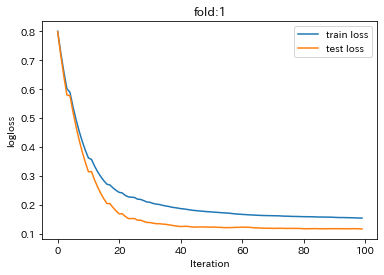

[I 2021-12-14 11:00:57,663] A new study created in memory with name: no-name-d7c22d01-ce61-4d9d-9e14-6796a227167b


Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:58,191] Trial 0 finished with value: 0.13994418704103495 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.13994418704103495.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13843	Test's rmse: 0.139944
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:58,650] Trial 1 finished with value: 0.14710635110074297 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.13994418704103495.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.125099	Test's rmse: 0.147106
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:59,029] Trial 2 finished with value: 0.15724019798427236 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.13994418704103495.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131589	Test's rmse: 0.15724
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:59,507] Trial 3 finished with value: 0.14330992029027448 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.13994418704103495.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.125483	Test's rmse: 0.14331
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:00:59,855] Trial 4 finished with value: 0.16857209965860429 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.13994418704103495.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142131	Test's rmse: 0.168572
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:00,284] Trial 5 finished with value: 0.14602074210330948 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.13994418704103495.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.126301	Test's rmse: 0.146021
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:00,803] Trial 6 finished with value: 0.14255042142700242 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.13994418704103495.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14364	Test's rmse: 0.14255
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:02,581] Trial 7 finished with value: 0.14272867853456458 and parameters: {'num_leaves': 212}. Best is trial 7 with value: 0.14272867853456458.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137439	Test's rmse: 0.142729
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:04,144] Trial 8 finished with value: 0.1435797765216618 and parameters: {'num_leaves': 175}. Best is trial 7 with value: 0.14272867853456458.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137164	Test's rmse: 0.14358
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:05,937] Trial 9 finished with value: 0.14401603505702623 and parameters: {'num_leaves': 217}. Best is trial 7 with value: 0.14272867853456458.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135651	Test's rmse: 0.144016
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:06,523] Trial 10 finished with value: 0.1407716750224107 and parameters: {'num_leaves': 38}. Best is trial 10 with value: 0.1407716750224107.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138045	Test's rmse: 0.140772
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:07,121] Trial 11 finished with value: 0.13988802562625374 and parameters: {'num_leaves': 41}. Best is trial 11 with value: 0.13988802562625374.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136506	Test's rmse: 0.139888
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:08,283] Trial 12 finished with value: 0.1430615903235442 and parameters: {'num_leaves': 116}. Best is trial 11 with value: 0.13988802562625374.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137451	Test's rmse: 0.143062
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:09,339] Trial 13 finished with value: 0.14294159283058488 and parameters: {'num_leaves': 102}. Best is trial 11 with value: 0.13988802562625374.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138057	Test's rmse: 0.142942
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:10,435] Trial 14 finished with value: 0.1416833178930542 and parameters: {'num_leaves': 109}. Best is trial 11 with value: 0.13988802562625374.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139017	Test's rmse: 0.141683
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:12,048] Trial 15 finished with value: 0.14304070978932942 and parameters: {'num_leaves': 185}. Best is trial 11 with value: 0.13988802562625374.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142753	Test's rmse: 0.143041
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:13,440] Trial 16 finished with value: 0.14408920424202584 and parameters: {'num_leaves': 152}. Best is trial 11 with value: 0.13988802562625374.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137914	Test's rmse: 0.144089
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:13,863] Trial 17 finished with value: 0.1401816355510974 and parameters: {'num_leaves': 21}. Best is trial 11 with value: 0.13988802562625374.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138644	Test's rmse: 0.140182
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:14,085] Trial 18 finished with value: 0.15044270532622725 and parameters: {'num_leaves': 5}. Best is trial 11 with value: 0.13988802562625374.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.159071	Test's rmse: 0.150443
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:14,825] Trial 19 finished with value: 0.1399623353881028 and parameters: {'num_leaves': 59}. Best is trial 11 with value: 0.13988802562625374.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13937	Test's rmse: 0.139962
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:15,601] Trial 20 finished with value: 0.14005936222139903 and parameters: {'num_leaves': 63}. Best is trial 11 with value: 0.13988802562625374.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136584	Test's rmse: 0.140059
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:16,401] Trial 21 finished with value: 0.13934517205197094 and parameters: {'num_leaves': 69}. Best is trial 21 with value: 0.13934517205197094.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138414	Test's rmse: 0.139345
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:17,252] Trial 22 finished with value: 0.14197581237145665 and parameters: {'num_leaves': 73}. Best is trial 21 with value: 0.13934517205197094.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137145	Test's rmse: 0.141976
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:17,822] Trial 23 finished with value: 0.140302484815593 and parameters: {'num_leaves': 37}. Best is trial 21 with value: 0.13934517205197094.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138437	Test's rmse: 0.140302
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:18,758] Trial 24 finished with value: 0.14394692851849758 and parameters: {'num_leaves': 86}. Best is trial 21 with value: 0.13934517205197094.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137936	Test's rmse: 0.143947
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:20,754] Trial 25 finished with value: 0.14450466569978213 and parameters: {'num_leaves': 251}. Best is trial 21 with value: 0.13934517205197094.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141606	Test's rmse: 0.144505
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:22,070] Trial 26 finished with value: 0.14417503955486077 and parameters: {'num_leaves': 139}. Best is trial 21 with value: 0.13934517205197094.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137515	Test's rmse: 0.144175
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:22,922] Trial 27 finished with value: 0.16934617171858898 and parameters: {'bagging_fraction': 0.43259283930372, 'bagging_freq': 5}. Best is trial 27 with value: 0.16934617171858898.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.185594	Test's rmse: 0.169346
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:23,772] Trial 28 finished with value: 0.15704081720148705 and parameters: {'bagging_fraction': 0.4078971352446612, 'bagging_freq': 7}. Best is trial 28 with value: 0.15704081720148705.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.191186	Test's rmse: 0.157041
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:24,674] Trial 29 finished with value: 0.14216836920582634 and parameters: {'bagging_fraction': 0.9872990258314618, 'bagging_freq': 4}. Best is trial 29 with value: 0.14216836920582634.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139039	Test's rmse: 0.142168
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:25,484] Trial 30 finished with value: 0.1448230152251002 and parameters: {'bagging_fraction': 0.9619197597991193, 'bagging_freq': 1}. Best is trial 29 with value: 0.14216836920582634.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137834	Test's rmse: 0.144823
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:26,389] Trial 31 finished with value: 0.15414762499781032 and parameters: {'bagging_fraction': 0.8170515903572853, 'bagging_freq': 2}. Best is trial 29 with value: 0.14216836920582634.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.157791	Test's rmse: 0.154148
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:27,265] Trial 32 finished with value: 0.16286526628254488 and parameters: {'bagging_fraction': 0.6207147071444378, 'bagging_freq': 7}. Best is trial 29 with value: 0.14216836920582634.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.171802	Test's rmse: 0.162865
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:28,142] Trial 33 finished with value: 0.14934141528639852 and parameters: {'bagging_fraction': 0.7766694354791562, 'bagging_freq': 7}. Best is trial 29 with value: 0.14216836920582634.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.165394	Test's rmse: 0.149341
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:29,020] Trial 34 finished with value: 0.15521728602826812 and parameters: {'bagging_fraction': 0.6909817961210448, 'bagging_freq': 5}. Best is trial 29 with value: 0.14216836920582634.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.166825	Test's rmse: 0.155217
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:29,910] Trial 35 finished with value: 0.15940736089249524 and parameters: {'bagging_fraction': 0.7244683876966307, 'bagging_freq': 2}. Best is trial 29 with value: 0.14216836920582634.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.162604	Test's rmse: 0.159407
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:30,790] Trial 36 finished with value: 0.15665017782321122 and parameters: {'bagging_fraction': 0.7455406368527099, 'bagging_freq': 6}. Best is trial 29 with value: 0.14216836920582634.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.16387	Test's rmse: 0.15665
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:31,634] Trial 37 finished with value: 0.14000801608415409 and parameters: {'feature_fraction': 0.9799999999999999}. Best is trial 37 with value: 0.14000801608415409.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141846	Test's rmse: 0.140008
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:32,479] Trial 38 finished with value: 0.14000801608415409 and parameters: {'feature_fraction': 0.948}. Best is trial 37 with value: 0.14000801608415409.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141846	Test's rmse: 0.140008
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:33,300] Trial 39 finished with value: 0.13934517205197094 and parameters: {'feature_fraction': 0.9159999999999999}. Best is trial 39 with value: 0.13934517205197094.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138414	Test's rmse: 0.139345
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:34,096] Trial 40 finished with value: 0.14344051853492507 and parameters: {'feature_fraction': 0.8839999999999999}. Best is trial 39 with value: 0.13934517205197094.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131724	Test's rmse: 0.143441
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:34,882] Trial 41 finished with value: 0.14344051853492507 and parameters: {'feature_fraction': 0.852}. Best is trial 39 with value: 0.13934517205197094.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131724	Test's rmse: 0.143441
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:35,644] Trial 42 finished with value: 0.1456138110891818 and parameters: {'feature_fraction': 0.82}. Best is trial 39 with value: 0.13934517205197094.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.126083	Test's rmse: 0.145614
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:36,165] Trial 43 finished with value: 0.1442663356242865 and parameters: {'lambda_l1': 3.5163266406072484, 'lambda_l2': 3.7914534288777316e-06}. Best is trial 43 with value: 0.1442663356242865.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13171	Test's rmse: 0.144266
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:36,967] Trial 44 finished with value: 0.14358654631212844 and parameters: {'lambda_l1': 7.789938172107839e-06, 'lambda_l2': 8.746272741386271e-07}. Best is trial 44 with value: 0.14358654631212844.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13714	Test's rmse: 0.143587
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:37,734] Trial 45 finished with value: 0.1411797689012884 and parameters: {'lambda_l1': 4.039258806470594e-06, 'lambda_l2': 2.485931016277889}. Best is trial 45 with value: 0.1411797689012884.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139662	Test's rmse: 0.14118
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:38,548] Trial 46 finished with value: 0.1400770937839058 and parameters: {'lambda_l1': 2.7704112684504507e-07, 'lambda_l2': 0.00020228283621906082}. Best is trial 46 with value: 0.1400770937839058.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138034	Test's rmse: 0.140077
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:39,045] Trial 47 finished with value: 0.15063846408725262 and parameters: {'lambda_l1': 3.316812611334454, 'lambda_l2': 3.446129089519841e-07}. Best is trial 46 with value: 0.1400770937839058.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136401	Test's rmse: 0.150638
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:39,443] Trial 48 finished with value: 0.1588448027506526 and parameters: {'lambda_l1': 7.99796739672694, 'lambda_l2': 1.4771525698706692e-07}. Best is trial 46 with value: 0.1400770937839058.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152222	Test's rmse: 0.158845
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:40,185] Trial 49 finished with value: 0.14358141440231986 and parameters: {'lambda_l1': 0.1836807480094503, 'lambda_l2': 3.0007571442193338e-06}. Best is trial 46 with value: 0.1400770937839058.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139916	Test's rmse: 0.143581
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:40,936] Trial 50 finished with value: 0.14245841194342818 and parameters: {'lambda_l1': 0.1344429703270153, 'lambda_l2': 0.000871428453077929}. Best is trial 46 with value: 0.1400770937839058.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138627	Test's rmse: 0.142458
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:41,751] Trial 51 finished with value: 0.14182735983481512 and parameters: {'lambda_l1': 4.9403967453658906e-05, 'lambda_l2': 0.08525389120666373}. Best is trial 46 with value: 0.1400770937839058.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139436	Test's rmse: 0.141827
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:42,585] Trial 52 finished with value: 0.14260072631123583 and parameters: {'lambda_l1': 0.0002717935858543392, 'lambda_l2': 1.5826299451215208e-06}. Best is trial 46 with value: 0.1400770937839058.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138249	Test's rmse: 0.142601
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:43,423] Trial 53 finished with value: 0.13926055967111617 and parameters: {'lambda_l1': 1.5652133104560802e-07, 'lambda_l2': 0.0029345179324329253}. Best is trial 53 with value: 0.13926055967111617.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13693	Test's rmse: 0.139261
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:44,253] Trial 54 finished with value: 0.14105137243131902 and parameters: {'lambda_l1': 1.424044161086113e-08, 'lambda_l2': 0.000898176434986419}. Best is trial 53 with value: 0.13926055967111617.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139206	Test's rmse: 0.141051
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:45,065] Trial 55 finished with value: 0.13966336867448878 and parameters: {'lambda_l1': 4.374457982722596e-08, 'lambda_l2': 0.033071618471077965}. Best is trial 53 with value: 0.13926055967111617.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136179	Test's rmse: 0.139663
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:45,897] Trial 56 finished with value: 0.1408976629315883 and parameters: {'lambda_l1': 1.010230687746968e-08, 'lambda_l2': 0.03428703218617973}. Best is trial 53 with value: 0.13926055967111617.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142281	Test's rmse: 0.140898
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:46,719] Trial 57 finished with value: 0.14157962154565468 and parameters: {'lambda_l1': 2.941515402091924e-07, 'lambda_l2': 0.03081955902059169}. Best is trial 53 with value: 0.13926055967111617.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143405	Test's rmse: 0.14158
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:47,520] Trial 58 finished with value: 0.1448905271351322 and parameters: {'lambda_l1': 2.1947649269672696e-07, 'lambda_l2': 2.7226292204120415}. Best is trial 53 with value: 0.13926055967111617.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139073	Test's rmse: 0.144891
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:48,356] Trial 59 finished with value: 0.14236261690441598 and parameters: {'lambda_l1': 0.002273351598441009, 'lambda_l2': 0.00011143893034960858}. Best is trial 53 with value: 0.13926055967111617.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136822	Test's rmse: 0.142363
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:49,177] Trial 60 finished with value: 0.14057802542878395 and parameters: {'lambda_l1': 2.118423103837069e-06, 'lambda_l2': 0.18479267814576233}. Best is trial 53 with value: 0.13926055967111617.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138325	Test's rmse: 0.140578
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:49,983] Trial 61 finished with value: 0.13934517216618741 and parameters: {'lambda_l1': 6.999118689839693e-08, 'lambda_l2': 1.280416831664622e-08}. Best is trial 53 with value: 0.13926055967111617.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138414	Test's rmse: 0.139345
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:50,799] Trial 62 finished with value: 0.14281462769522776 and parameters: {'lambda_l1': 0.007839893215079333, 'lambda_l2': 1.7247114327952388e-05}. Best is trial 53 with value: 0.13926055967111617.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142471	Test's rmse: 0.142815
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:51,629] Trial 63 finished with value: 0.14819879331946642 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.14819879331946642.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0633685	Test's rmse: 0.148199
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:52,460] Trial 64 finished with value: 0.15234014821483 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.14819879331946642.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.156148	Test's rmse: 0.15234
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:53,244] Trial 65 finished with value: 0.1934609209992296 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.14819879331946642.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.288653	Test's rmse: 0.193461
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:54,076] Trial 66 finished with value: 0.17244715213681622 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.14819879331946642.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.23722	Test's rmse: 0.172447
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:54,753] Trial 67 finished with value: 0.15071308902569464 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.14819879331946642.


Early stopping, best iteration is:
[32]	Train's rmse: 0.0770644	Test's rmse: 0.150713


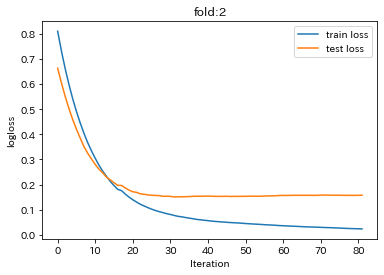

[I 2021-12-14 11:01:55,024] A new study created in memory with name: no-name-a5dc0214-2e90-47b1-b4f8-c281fd96d830


Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:55,520] Trial 0 finished with value: 0.021515966371072746 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.021515966371072746.


Early stopping, best iteration is:
[45]	Train's rmse: 0.171356	Test's rmse: 0.021516
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:55,877] Trial 1 finished with value: 0.10710132456308936 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.021515966371072746.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143185	Test's rmse: 0.107101
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:56,270] Trial 2 finished with value: 0.10076973216274258 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.021515966371072746.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140062	Test's rmse: 0.10077
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:56,736] Trial 3 finished with value: 0.07108500991777447 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.021515966371072746.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13262	Test's rmse: 0.071085
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:57,230] Trial 4 finished with value: 0.03336565499225528 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.021515966371072746.


Early stopping, best iteration is:
[45]	Train's rmse: 0.167152	Test's rmse: 0.0333657
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:57,658] Trial 5 finished with value: 0.08180852421154645 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.021515966371072746.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13093	Test's rmse: 0.0818085
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:58,150] Trial 6 finished with value: 0.0523820520220319 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.021515966371072746.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133649	Test's rmse: 0.0523821
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:01:59,758] Trial 7 finished with value: 0.029893124052637818 and parameters: {'num_leaves': 172}. Best is trial 7 with value: 0.029893124052637818.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154232	Test's rmse: 0.0298931
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:01,813] Trial 8 finished with value: 0.030677732331890372 and parameters: {'num_leaves': 245}. Best is trial 7 with value: 0.029893124052637818.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15417	Test's rmse: 0.0306777
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:03,327] Trial 9 finished with value: 0.030220990868136927 and parameters: {'num_leaves': 155}. Best is trial 7 with value: 0.029893124052637818.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15439	Test's rmse: 0.030221
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:04,657] Trial 10 finished with value: 0.030486692600348187 and parameters: {'num_leaves': 128}. Best is trial 7 with value: 0.029893124052637818.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15432	Test's rmse: 0.0304867
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:06,502] Trial 11 finished with value: 0.029039850060515293 and parameters: {'num_leaves': 211}. Best is trial 11 with value: 0.029039850060515293.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154276	Test's rmse: 0.0290399
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:06,808] Trial 12 finished with value: 0.02076744258643258 and parameters: {'num_leaves': 12}. Best is trial 12 with value: 0.02076744258643258.


Early stopping, best iteration is:
[44]	Train's rmse: 0.175084	Test's rmse: 0.0207674
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:07,862] Trial 13 finished with value: 0.030356318320230016 and parameters: {'num_leaves': 95}. Best is trial 12 with value: 0.02076744258643258.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154243	Test's rmse: 0.0303563
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:09,952] Trial 14 finished with value: 0.029979099740833726 and parameters: {'num_leaves': 248}. Best is trial 12 with value: 0.02076744258643258.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154155	Test's rmse: 0.0299791
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:11,964] Trial 15 finished with value: 0.03040868059909776 and parameters: {'num_leaves': 241}. Best is trial 12 with value: 0.02076744258643258.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154176	Test's rmse: 0.0304087
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:12,631] Trial 16 finished with value: 0.020148371062667043 and parameters: {'num_leaves': 52}. Best is trial 16 with value: 0.020148371062667043.


Early stopping, best iteration is:
[42]	Train's rmse: 0.171693	Test's rmse: 0.0201484
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:13,168] Trial 17 finished with value: 0.020707617894301866 and parameters: {'num_leaves': 33}. Best is trial 16 with value: 0.020148371062667043.


Early stopping, best iteration is:
[46]	Train's rmse: 0.169784	Test's rmse: 0.0207076
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:13,644] Trial 18 finished with value: 0.022199706154197228 and parameters: {'num_leaves': 27}. Best is trial 16 with value: 0.020148371062667043.


Early stopping, best iteration is:
[47]	Train's rmse: 0.167305	Test's rmse: 0.0221997
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:14,438] Trial 19 finished with value: 0.021272099249574475 and parameters: {'num_leaves': 64}. Best is trial 16 with value: 0.020148371062667043.


Early stopping, best iteration is:
[48]	Train's rmse: 0.170716	Test's rmse: 0.0212721
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:15,211] Trial 20 finished with value: 0.02182813508212381 and parameters: {'num_leaves': 60}. Best is trial 16 with value: 0.020148371062667043.


Early stopping, best iteration is:
[48]	Train's rmse: 0.170715	Test's rmse: 0.0218281
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:15,885] Trial 21 finished with value: 0.019478195384959915 and parameters: {'num_leaves': 54}. Best is trial 21 with value: 0.019478195384959915.


Early stopping, best iteration is:
[44]	Train's rmse: 0.170422	Test's rmse: 0.0194782
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:16,895] Trial 22 finished with value: 0.03056117904766165 and parameters: {'num_leaves': 89}. Best is trial 21 with value: 0.019478195384959915.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154152	Test's rmse: 0.0305612
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:18,040] Trial 23 finished with value: 0.029274865204572845 and parameters: {'num_leaves': 105}. Best is trial 21 with value: 0.019478195384959915.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154256	Test's rmse: 0.0292749
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:18,719] Trial 24 finished with value: 0.01983916042335935 and parameters: {'num_leaves': 53}. Best is trial 21 with value: 0.019478195384959915.


Early stopping, best iteration is:
[46]	Train's rmse: 0.169874	Test's rmse: 0.0198392
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:19,028] Trial 25 finished with value: 0.029531973046604054 and parameters: {'num_leaves': 10}. Best is trial 21 with value: 0.019478195384959915.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.160558	Test's rmse: 0.029532
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:19,874] Trial 26 finished with value: 0.021725509859623793 and parameters: {'num_leaves': 74}. Best is trial 21 with value: 0.019478195384959915.


Early stopping, best iteration is:
[46]	Train's rmse: 0.169072	Test's rmse: 0.0217255
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:20,673] Trial 27 finished with value: 0.027410302491205157 and parameters: {'bagging_fraction': 0.5326366846530342, 'bagging_freq': 5}. Best is trial 27 with value: 0.027410302491205157.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.184259	Test's rmse: 0.0274103
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:21,360] Trial 28 finished with value: 0.024056904247341995 and parameters: {'bagging_fraction': 0.6424530355917678, 'bagging_freq': 4}. Best is trial 28 with value: 0.024056904247341995.


Early stopping, best iteration is:
[37]	Train's rmse: 0.195926	Test's rmse: 0.0240569
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:22,137] Trial 29 finished with value: 0.027296814931795407 and parameters: {'bagging_fraction': 0.5394778026552891, 'bagging_freq': 6}. Best is trial 28 with value: 0.024056904247341995.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.179064	Test's rmse: 0.0272968
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:22,915] Trial 30 finished with value: 0.027228264174608385 and parameters: {'bagging_fraction': 0.49277027467962425, 'bagging_freq': 5}. Best is trial 28 with value: 0.024056904247341995.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.183192	Test's rmse: 0.0272283
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:23,715] Trial 31 finished with value: 0.02681337127950329 and parameters: {'bagging_fraction': 0.6451434974533591, 'bagging_freq': 5}. Best is trial 28 with value: 0.024056904247341995.


Did not meet early stopping. Best iteration is:
[95]	Train's rmse: 0.173152	Test's rmse: 0.0268134
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:24,529] Trial 32 finished with value: 0.02656103330611082 and parameters: {'bagging_fraction': 0.9418356550856173, 'bagging_freq': 6}. Best is trial 28 with value: 0.024056904247341995.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.159412	Test's rmse: 0.026561
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:25,283] Trial 33 finished with value: 0.021113225396545386 and parameters: {'bagging_fraction': 0.9892103529622615, 'bagging_freq': 3}. Best is trial 33 with value: 0.021113225396545386.


Early stopping, best iteration is:
[42]	Train's rmse: 0.170922	Test's rmse: 0.0211132
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:26,079] Trial 34 finished with value: 0.029120336680089082 and parameters: {'bagging_fraction': 0.638067380009519, 'bagging_freq': 5}. Best is trial 33 with value: 0.021113225396545386.


Did not meet early stopping. Best iteration is:
[95]	Train's rmse: 0.174825	Test's rmse: 0.0291203
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:26,813] Trial 35 finished with value: 0.02516529802698521 and parameters: {'bagging_fraction': 0.944926105503046, 'bagging_freq': 1}. Best is trial 33 with value: 0.021113225396545386.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.164336	Test's rmse: 0.0251653
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:27,537] Trial 36 finished with value: 0.026060951171749017 and parameters: {'bagging_fraction': 0.6747649561116082, 'bagging_freq': 1}. Best is trial 33 with value: 0.021113225396545386.


Early stopping, best iteration is:
[48]	Train's rmse: 0.188971	Test's rmse: 0.026061
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:28,231] Trial 37 finished with value: 0.035537681657503706 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 37 with value: 0.035537681657503706.


Early stopping, best iteration is:
[46]	Train's rmse: 0.167953	Test's rmse: 0.0355377
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:28,897] Trial 38 finished with value: 0.03751919616002363 and parameters: {'feature_fraction': 0.92}. Best is trial 37 with value: 0.035537681657503706.


Early stopping, best iteration is:
[45]	Train's rmse: 0.174939	Test's rmse: 0.0375192
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:29,591] Trial 39 finished with value: 0.035537681657503706 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 37 with value: 0.035537681657503706.


Early stopping, best iteration is:
[46]	Train's rmse: 0.167953	Test's rmse: 0.0355377
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:30,102] Trial 40 finished with value: 0.021331900891008098 and parameters: {'lambda_l1': 0.10694188139837427, 'lambda_l2': 0.001153408666098998}. Best is trial 40 with value: 0.021331900891008098.


Early stopping, best iteration is:
[44]	Train's rmse: 0.17027	Test's rmse: 0.0213319
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:30,803] Trial 41 finished with value: 0.020096614830623912 and parameters: {'lambda_l1': 8.549708148104767e-05, 'lambda_l2': 3.8494978444673e-06}. Best is trial 41 with value: 0.020096614830623912.


Early stopping, best iteration is:
[46]	Train's rmse: 0.169831	Test's rmse: 0.0200966
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:31,460] Trial 42 finished with value: 0.020853181510221863 and parameters: {'lambda_l1': 2.2029504543942243e-06, 'lambda_l2': 0.10069953684709287}. Best is trial 41 with value: 0.020096614830623912.


Early stopping, best iteration is:
[45]	Train's rmse: 0.171746	Test's rmse: 0.0208532
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:32,030] Trial 43 finished with value: 0.020633220602642596 and parameters: {'lambda_l1': 0.0019257434190061958, 'lambda_l2': 2.5172442598529696}. Best is trial 41 with value: 0.020096614830623912.


Early stopping, best iteration is:
[44]	Train's rmse: 0.172774	Test's rmse: 0.0206332
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:32,681] Trial 44 finished with value: 0.028244053584749632 and parameters: {'lambda_l1': 4.9449660963757556e-05, 'lambda_l2': 1.8076461549738863}. Best is trial 41 with value: 0.020096614830623912.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.156084	Test's rmse: 0.0282441
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:33,159] Trial 45 finished with value: 0.02135342326987875 and parameters: {'lambda_l1': 0.15494903789216313, 'lambda_l2': 1.4213596297754526e-06}. Best is trial 41 with value: 0.020096614830623912.


Early stopping, best iteration is:
[42]	Train's rmse: 0.170446	Test's rmse: 0.0213534
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:33,860] Trial 46 finished with value: 0.020179148928803077 and parameters: {'lambda_l1': 1.5352302036713485e-05, 'lambda_l2': 2.469606276493416e-07}. Best is trial 41 with value: 0.020096614830623912.


Early stopping, best iteration is:
[46]	Train's rmse: 0.169804	Test's rmse: 0.0201791
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:34,485] Trial 47 finished with value: 0.02719865055163587 and parameters: {'lambda_l1': 1.54891762365708e-08, 'lambda_l2': 3.757266937011973}. Best is trial 41 with value: 0.020096614830623912.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.155113	Test's rmse: 0.0271987
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:35,174] Trial 48 finished with value: 0.020065428403959796 and parameters: {'lambda_l1': 1.9511331726937222e-07, 'lambda_l2': 0.00039984717708864713}. Best is trial 48 with value: 0.020065428403959796.


Early stopping, best iteration is:
[44]	Train's rmse: 0.170137	Test's rmse: 0.0200654
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:35,811] Trial 49 finished with value: 0.021082494463979706 and parameters: {'lambda_l1': 0.0007031179415194036, 'lambda_l2': 0.119905258789204}. Best is trial 48 with value: 0.020065428403959796.


Early stopping, best iteration is:
[44]	Train's rmse: 0.171431	Test's rmse: 0.0210825
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:36,515] Trial 50 finished with value: 0.020177051524026775 and parameters: {'lambda_l1': 2.0556690502289357e-08, 'lambda_l2': 6.360273675028023e-05}. Best is trial 48 with value: 0.020065428403959796.


Early stopping, best iteration is:
[46]	Train's rmse: 0.169804	Test's rmse: 0.0201771
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:37,202] Trial 51 finished with value: 0.019461151091333246 and parameters: {'lambda_l1': 7.308974185040535e-07, 'lambda_l2': 4.160555086603356e-05}. Best is trial 51 with value: 0.019461151091333246.


Early stopping, best iteration is:
[44]	Train's rmse: 0.170423	Test's rmse: 0.0194612
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:37,885] Trial 52 finished with value: 0.019478196210858462 and parameters: {'lambda_l1': 7.939646029266992e-07, 'lambda_l2': 1.1407498050224484e-08}. Best is trial 51 with value: 0.019461151091333246.


Early stopping, best iteration is:
[44]	Train's rmse: 0.170422	Test's rmse: 0.0194782
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:38,578] Trial 53 finished with value: 0.01946115901100107 and parameters: {'lambda_l1': 1.4227204443090732e-06, 'lambda_l2': 1.8389125438448738e-08}. Best is trial 51 with value: 0.019461151091333246.


Early stopping, best iteration is:
[44]	Train's rmse: 0.170422	Test's rmse: 0.0194612
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:39,267] Trial 54 finished with value: 0.019461160290186005 and parameters: {'lambda_l1': 2.635958261753233e-06, 'lambda_l2': 1.427741446076789e-08}. Best is trial 51 with value: 0.019461151091333246.


Early stopping, best iteration is:
[44]	Train's rmse: 0.170422	Test's rmse: 0.0194612
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:39,559] Trial 55 finished with value: 0.028005238066850666 and parameters: {'lambda_l1': 8.987528473020232, 'lambda_l2': 8.026162296058577e-06}. Best is trial 51 with value: 0.019461151091333246.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.156311	Test's rmse: 0.0280052
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:40,240] Trial 56 finished with value: 0.019989780174585373 and parameters: {'lambda_l1': 1.226934014254668e-07, 'lambda_l2': 0.005846401460257242}. Best is trial 51 with value: 0.019461151091333246.


Early stopping, best iteration is:
[44]	Train's rmse: 0.170489	Test's rmse: 0.0199898
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:40,935] Trial 57 finished with value: 0.020179146783274742 and parameters: {'lambda_l1': 5.887864014356469e-06, 'lambda_l2': 3.115678478985826e-07}. Best is trial 51 with value: 0.019461151091333246.


Early stopping, best iteration is:
[46]	Train's rmse: 0.169804	Test's rmse: 0.0201791
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:41,564] Trial 58 finished with value: 0.02013952334786432 and parameters: {'lambda_l1': 0.00813472201469597, 'lambda_l2': 4.2790274565298444e-05}. Best is trial 51 with value: 0.019461151091333246.


Early stopping, best iteration is:
[44]	Train's rmse: 0.17046	Test's rmse: 0.0201395
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:42,267] Trial 59 finished with value: 0.019478195564853907 and parameters: {'lambda_l1': 2.2460414179823803e-07, 'lambda_l2': 1.5843456169738218e-07}. Best is trial 51 with value: 0.019461151091333246.


Early stopping, best iteration is:
[44]	Train's rmse: 0.170422	Test's rmse: 0.0194782
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:42,971] Trial 60 finished with value: 0.05652299194768678 and parameters: {'min_child_samples': 50}. Best is trial 60 with value: 0.05652299194768678.


Early stopping, best iteration is:
[39]	Train's rmse: 0.260116	Test's rmse: 0.056523
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:43,541] Trial 61 finished with value: 0.09210194193512578 and parameters: {'min_child_samples': 100}. Best is trial 60 with value: 0.05652299194768678.


Early stopping, best iteration is:
[27]	Train's rmse: 0.320858	Test's rmse: 0.0921019
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:44,282] Trial 62 finished with value: 0.027595972137346922 and parameters: {'min_child_samples': 25}. Best is trial 62 with value: 0.027595972137346922.


Early stopping, best iteration is:
[47]	Train's rmse: 0.176661	Test's rmse: 0.027596
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:44,936] Trial 63 finished with value: 0.026945775405204507 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.026945775405204507.


Early stopping, best iteration is:
[42]	Train's rmse: 0.108142	Test's rmse: 0.0269458
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:45,536] Trial 64 finished with value: 0.027446256532654596 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.026945775405204507.


Early stopping, best iteration is:
[39]	Train's rmse: 0.0538572	Test's rmse: 0.0274463


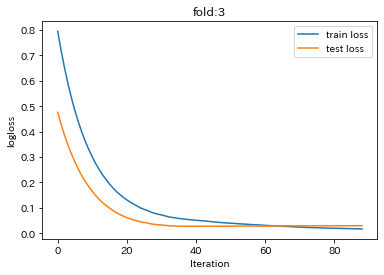

[I 2021-12-14 11:02:45,747] A new study created in memory with name: no-name-2b185262-1a3a-407c-bfc6-3e0b180dd6d0


Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:46,199] Trial 0 finished with value: 0.3677959708674583 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.3677959708674583.


Early stopping, best iteration is:
[35]	Train's rmse: 0.160637	Test's rmse: 0.367796
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:46,663] Trial 1 finished with value: 0.3616610314432225 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 0.3616610314432225.


Early stopping, best iteration is:
[37]	Train's rmse: 0.155527	Test's rmse: 0.361661
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:47,014] Trial 2 finished with value: 0.4099308941595869 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 0.3616610314432225.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.125349	Test's rmse: 0.409931
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:47,484] Trial 3 finished with value: 0.3896414290345304 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 0.3616610314432225.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.123143	Test's rmse: 0.389641
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:47,956] Trial 4 finished with value: 0.37862690099873014 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 0.3616610314432225.


Early stopping, best iteration is:
[43]	Train's rmse: 0.156697	Test's rmse: 0.378627
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:48,384] Trial 5 finished with value: 0.39024057899691666 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.3616610314432225.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.118338	Test's rmse: 0.390241
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:48,786] Trial 6 finished with value: 0.4079148478437691 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 0.3616610314432225.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.124112	Test's rmse: 0.407915
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:49,107] Trial 7 finished with value: 0.3621460945492203 and parameters: {'num_leaves': 15}. Best is trial 7 with value: 0.3621460945492203.


Early stopping, best iteration is:
[32]	Train's rmse: 0.161209	Test's rmse: 0.362146
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:50,296] Trial 8 finished with value: 0.35810173509199505 and parameters: {'num_leaves': 158}. Best is trial 8 with value: 0.35810173509199505.


Early stopping, best iteration is:
[34]	Train's rmse: 0.158495	Test's rmse: 0.358102
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:51,824] Trial 9 finished with value: 0.358101949623936 and parameters: {'num_leaves': 228}. Best is trial 8 with value: 0.35810173509199505.


Early stopping, best iteration is:
[34]	Train's rmse: 0.158493	Test's rmse: 0.358102
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:53,190] Trial 10 finished with value: 0.35810184653732186 and parameters: {'num_leaves': 197}. Best is trial 8 with value: 0.35810173509199505.


Early stopping, best iteration is:
[34]	Train's rmse: 0.158493	Test's rmse: 0.358102
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:53,996] Trial 11 finished with value: 0.3584898866476675 and parameters: {'num_leaves': 80}. Best is trial 8 with value: 0.35810173509199505.


Early stopping, best iteration is:
[34]	Train's rmse: 0.158676	Test's rmse: 0.35849
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:54,280] Trial 12 finished with value: 0.35489006136081336 and parameters: {'num_leaves': 11}. Best is trial 12 with value: 0.35489006136081336.


Early stopping, best iteration is:
[38]	Train's rmse: 0.153231	Test's rmse: 0.35489
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:54,532] Trial 13 finished with value: 0.3458879680613858 and parameters: {'num_leaves': 8}. Best is trial 13 with value: 0.3458879680613858.


Early stopping, best iteration is:
[38]	Train's rmse: 0.155992	Test's rmse: 0.345888
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:54,767] Trial 14 finished with value: 0.35106578615243067 and parameters: {'num_leaves': 7}. Best is trial 13 with value: 0.3458879680613858.


Early stopping, best iteration is:
[36]	Train's rmse: 0.159811	Test's rmse: 0.351066
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:56,427] Trial 15 finished with value: 0.35810191370706407 and parameters: {'num_leaves': 254}. Best is trial 13 with value: 0.3458879680613858.


Early stopping, best iteration is:
[34]	Train's rmse: 0.158493	Test's rmse: 0.358102
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:57,258] Trial 16 finished with value: 0.35809745452846126 and parameters: {'num_leaves': 86}. Best is trial 13 with value: 0.3458879680613858.


Early stopping, best iteration is:
[34]	Train's rmse: 0.15851	Test's rmse: 0.358097
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:57,958] Trial 17 finished with value: 0.3581000825429911 and parameters: {'num_leaves': 67}. Best is trial 13 with value: 0.3458879680613858.


Early stopping, best iteration is:
[34]	Train's rmse: 0.158498	Test's rmse: 0.3581
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:58,155] Trial 18 finished with value: 0.33969959921001297 and parameters: {'num_leaves': 4}. Best is trial 18 with value: 0.33969959921001297.


Early stopping, best iteration is:
[44]	Train's rmse: 0.171045	Test's rmse: 0.3397
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:58,726] Trial 19 finished with value: 0.35468036538324604 and parameters: {'num_leaves': 45}. Best is trial 18 with value: 0.33969959921001297.


Early stopping, best iteration is:
[35]	Train's rmse: 0.156291	Test's rmse: 0.35468
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:02:59,763] Trial 20 finished with value: 0.35810185356036145 and parameters: {'num_leaves': 124}. Best is trial 18 with value: 0.33969959921001297.


Early stopping, best iteration is:
[34]	Train's rmse: 0.1585	Test's rmse: 0.358102
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:03:00,888] Trial 21 finished with value: 0.35849633237021794 and parameters: {'num_leaves': 141}. Best is trial 18 with value: 0.33969959921001297.


Early stopping, best iteration is:
[34]	Train's rmse: 0.15867	Test's rmse: 0.358496
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:03:01,498] Trial 22 finished with value: 0.35847105675979174 and parameters: {'num_leaves': 50}. Best is trial 18 with value: 0.33969959921001297.


Early stopping, best iteration is:
[34]	Train's rmse: 0.158699	Test's rmse: 0.358471
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:03:02,407] Trial 23 finished with value: 0.35809911921385346 and parameters: {'num_leaves': 98}. Best is trial 18 with value: 0.33969959921001297.


Early stopping, best iteration is:
[34]	Train's rmse: 0.158498	Test's rmse: 0.358099
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:03:02,944] Trial 24 finished with value: 0.359270361425411 and parameters: {'num_leaves': 42}. Best is trial 18 with value: 0.33969959921001297.


Early stopping, best iteration is:
[34]	Train's rmse: 0.158175	Test's rmse: 0.35927
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:03:03,396] Trial 25 finished with value: 0.3606182473727808 and parameters: {'num_leaves': 29}. Best is trial 18 with value: 0.33969959921001297.


Early stopping, best iteration is:
[34]	Train's rmse: 0.158677	Test's rmse: 0.360618
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:03:04,353] Trial 26 finished with value: 0.35848610621687477 and parameters: {'num_leaves': 111}. Best is trial 18 with value: 0.33969959921001297.


Early stopping, best iteration is:
[34]	Train's rmse: 0.158688	Test's rmse: 0.358486
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:03:04,592] Trial 27 finished with value: 0.35035991274926764 and parameters: {'bagging_fraction': 0.9175564445121823, 'bagging_freq': 2}. Best is trial 27 with value: 0.35035991274926764.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152585	Test's rmse: 0.35036
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:03:04,797] Trial 28 finished with value: 0.3263701873042438 and parameters: {'bagging_fraction': 0.5453608968859275, 'bagging_freq': 7}. Best is trial 28 with value: 0.3263701873042438.


Did not meet early stopping. Best iteration is:
[84]	Train's rmse: 0.176852	Test's rmse: 0.32637
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:03:05,011] Trial 29 finished with value: 0.3468986000957785 and parameters: {'bagging_fraction': 0.7109966065633015, 'bagging_freq': 6}. Best is trial 28 with value: 0.3263701873042438.
[I 2021-12-14 11:03:05,206] Trial 30 finished with value: 0.3282669590622494 and parameters: {'bagging_fraction': 0.7018861246825039, 'bagging_freq': 7}. Best is trial 28 with value: 0.3263701873042438.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.164817	Test's rmse: 0.346899
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[35]	Train's rmse: 0.190685	Test's rmse: 0.328267


[I 2021-12-14 11:03:05,418] Trial 31 finished with value: 0.3367580063748093 and parameters: {'bagging_fraction': 0.7706088116415851, 'bagging_freq': 5}. Best is trial 28 with value: 0.3263701873042438.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.155609	Test's rmse: 0.336758


[I 2021-12-14 11:03:05,640] Trial 32 finished with value: 0.3406918378627573 and parameters: {'bagging_fraction': 0.7962319584696891, 'bagging_freq': 6}. Best is trial 28 with value: 0.3263701873042438.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.161073	Test's rmse: 0.340692


[I 2021-12-14 11:03:05,830] Trial 33 finished with value: 0.32937313934030227 and parameters: {'bagging_fraction': 0.567106880583063, 'bagging_freq': 5}. Best is trial 28 with value: 0.3263701873042438.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[40]	Train's rmse: 0.189089	Test's rmse: 0.329373
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:03:06,044] Trial 34 finished with value: 0.3441258013712974 and parameters: {'bagging_fraction': 0.6487862892611885, 'bagging_freq': 5}. Best is trial 28 with value: 0.3263701873042438.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.169615	Test's rmse: 0.344126
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:03:06,252] Trial 35 finished with value: 0.3284654949332423 and parameters: {'bagging_fraction': 0.6008127738400256, 'bagging_freq': 3}. Best is trial 28 with value: 0.3263701873042438.


Early stopping, best iteration is:
[44]	Train's rmse: 0.183436	Test's rmse: 0.328465
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:03:06,466] Trial 36 finished with value: 0.34139665793280477 and parameters: {'bagging_fraction': 0.5642353221135767, 'bagging_freq': 2}. Best is trial 28 with value: 0.3263701873042438.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.164726	Test's rmse: 0.341397
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:03:06,676] Trial 37 finished with value: 0.3185772605039488 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 37 with value: 0.3185772605039488.


Did not meet early stopping. Best iteration is:
[84]	Train's rmse: 0.174604	Test's rmse: 0.318577
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[84]	Train's rmse: 0.174604	Test's rmse: 0.318577


[I 2021-12-14 11:03:06,872] Trial 38 finished with value: 0.3185772605039488 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 37 with value: 0.3185772605039488.
[I 2021-12-14 11:03:07,073] Trial 39 finished with value: 0.3174244178679498 and parameters: {'feature_fraction': 0.92}. Best is trial 39 with value: 0.3174244178679498.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[84]	Train's rmse: 0.174627	Test's rmse: 0.317424


[I 2021-12-14 11:03:07,291] Trial 40 finished with value: 0.32134878998816574 and parameters: {'lambda_l1': 8.59307809353407, 'lambda_l2': 3.098794901977854e-06}. Best is trial 40 with value: 0.32134878998816574.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.184858	Test's rmse: 0.321349


[I 2021-12-14 11:03:07,491] Trial 41 finished with value: 0.31742123884391743 and parameters: {'lambda_l1': 0.0006457201810366651, 'lambda_l2': 0.01855777607120058}. Best is trial 41 with value: 0.31742123884391743.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[84]	Train's rmse: 0.174638	Test's rmse: 0.317421
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:03:07,691] Trial 42 finished with value: 0.3144668450881832 and parameters: {'lambda_l1': 1.7849838318770808, 'lambda_l2': 2.707076882693587e-07}. Best is trial 42 with value: 0.3144668450881832.


Did not meet early stopping. Best iteration is:
[86]	Train's rmse: 0.177459	Test's rmse: 0.314467
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[84]	Train's rmse: 0.174627	Test's rmse: 0.317424


[I 2021-12-14 11:03:07,890] Trial 43 finished with value: 0.3174244194641567 and parameters: {'lambda_l1': 3.507853137793396e-05, 'lambda_l2': 3.6175881604899697e-06}. Best is trial 42 with value: 0.3144668450881832.
[I 2021-12-14 11:03:08,106] Trial 44 finished with value: 0.31741676194446894 and parameters: {'lambda_l1': 0.0028159913663462085, 'lambda_l2': 0.004789187484455795}. Best is trial 42 with value: 0.3144668450881832.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[84]	Train's rmse: 0.174632	Test's rmse: 0.317417


[I 2021-12-14 11:03:08,313] Trial 45 finished with value: 0.3164644959955859 and parameters: {'lambda_l1': 0.5968686279145695, 'lambda_l2': 0.00012001618872726447}. Best is trial 42 with value: 0.3144668450881832.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[85]	Train's rmse: 0.175996	Test's rmse: 0.316464


[I 2021-12-14 11:03:08,523] Trial 46 finished with value: 0.31743291373003835 and parameters: {'lambda_l1': 1.0195264648216868e-06, 'lambda_l2': 0.06413620866962559}. Best is trial 42 with value: 0.3144668450881832.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[84]	Train's rmse: 0.174672	Test's rmse: 0.317433


[I 2021-12-14 11:03:08,734] Trial 47 finished with value: 0.32095425874789046 and parameters: {'lambda_l1': 0.0005712142605686836, 'lambda_l2': 8.724799653496925}. Best is trial 42 with value: 0.3144668450881832.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[84]	Train's rmse: 0.181984	Test's rmse: 0.320954


[I 2021-12-14 11:03:08,945] Trial 48 finished with value: 0.31742442941049914 and parameters: {'lambda_l1': 9.08264096761827e-06, 'lambda_l2': 3.54306744566971e-05}. Best is trial 42 with value: 0.3144668450881832.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[84]	Train's rmse: 0.174627	Test's rmse: 0.317424


[I 2021-12-14 11:03:09,146] Trial 49 finished with value: 0.31743241818056933 and parameters: {'lambda_l1': 0.019348668161302072, 'lambda_l2': 4.283786772344364e-08}. Best is trial 42 with value: 0.3144668450881832.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[84]	Train's rmse: 0.17466	Test's rmse: 0.317432


[I 2021-12-14 11:03:09,372] Trial 50 finished with value: 0.31742441786113007 and parameters: {'lambda_l1': 5.8967205668628125e-08, 'lambda_l2': 2.552722031835817e-08}. Best is trial 42 with value: 0.3144668450881832.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[84]	Train's rmse: 0.174627	Test's rmse: 0.317424


[I 2021-12-14 11:03:09,581] Trial 51 finished with value: 0.31445742600211585 and parameters: {'lambda_l1': 1.8687039687618967, 'lambda_l2': 0.00011020922875474377}. Best is trial 51 with value: 0.31445742600211585.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[86]	Train's rmse: 0.177572	Test's rmse: 0.314457


[I 2021-12-14 11:03:09,787] Trial 52 finished with value: 0.31546654138650376 and parameters: {'lambda_l1': 0.1988996185545145, 'lambda_l2': 2.437998938691433e-06}. Best is trial 51 with value: 0.31445742600211585.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[87]	Train's rmse: 0.174599	Test's rmse: 0.315467


[I 2021-12-14 11:03:09,997] Trial 53 finished with value: 0.32219854439070345 and parameters: {'lambda_l1': 9.228077019353305, 'lambda_l2': 2.525689457895361e-07}. Best is trial 51 with value: 0.31445742600211585.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.183654	Test's rmse: 0.322199


[I 2021-12-14 11:03:10,209] Trial 54 finished with value: 0.3155648904332181 and parameters: {'lambda_l1': 0.1576171372036404, 'lambda_l2': 0.0015100388177403579}. Best is trial 51 with value: 0.31445742600211585.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[86]	Train's rmse: 0.17453	Test's rmse: 0.315565


[I 2021-12-14 11:03:10,429] Trial 55 finished with value: 0.31809938288283657 and parameters: {'lambda_l1': 0.025531534330398245, 'lambda_l2': 0.48130581564222596}. Best is trial 51 with value: 0.31445742600211585.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[84]	Train's rmse: 0.175862	Test's rmse: 0.318099


[I 2021-12-14 11:03:10,635] Trial 56 finished with value: 0.3164681087111503 and parameters: {'lambda_l1': 1.1246293842254114, 'lambda_l2': 3.866647353132115e-05}. Best is trial 51 with value: 0.31445742600211585.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[84]	Train's rmse: 0.175721	Test's rmse: 0.316468


[I 2021-12-14 11:03:10,846] Trial 57 finished with value: 0.3174324098478516 and parameters: {'lambda_l1': 0.018609055176647675, 'lambda_l2': 3.8439362797554933e-07}. Best is trial 51 with value: 0.31445742600211585.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[84]	Train's rmse: 0.174659	Test's rmse: 0.317432


[I 2021-12-14 11:03:11,055] Trial 58 finished with value: 0.31582594753378657 and parameters: {'lambda_l1': 2.125181400210804, 'lambda_l2': 0.0008207638159020803}. Best is trial 51 with value: 0.31445742600211585.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[86]	Train's rmse: 0.178486	Test's rmse: 0.315826


[I 2021-12-14 11:03:11,275] Trial 59 finished with value: 0.31742442350530886 and parameters: {'lambda_l1': 1.609905833362855e-08, 'lambda_l2': 1.776152363154733e-05}. Best is trial 51 with value: 0.31445742600211585.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[84]	Train's rmse: 0.174627	Test's rmse: 0.317424


[I 2021-12-14 11:03:11,493] Trial 60 finished with value: 0.42266277310322614 and parameters: {'min_child_samples': 50}. Best is trial 60 with value: 0.42266277310322614.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[84]	Train's rmse: 0.221442	Test's rmse: 0.422663


[I 2021-12-14 11:03:11,684] Trial 61 finished with value: 0.35533299498687626 and parameters: {'min_child_samples': 5}. Best is trial 61 with value: 0.35533299498687626.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.112251	Test's rmse: 0.355333
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 11:03:11,890] Trial 62 finished with value: 0.5220687689847513 and parameters: {'min_child_samples': 100}. Best is trial 61 with value: 0.35533299498687626.


Did not meet early stopping. Best iteration is:
[85]	Train's rmse: 0.279376	Test's rmse: 0.522069
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[91]	Train's rmse: 0.181946	Test's rmse: 0.342844


[I 2021-12-14 11:03:12,094] Trial 63 finished with value: 0.34284413389131335 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.34284413389131335.
[I 2021-12-14 11:03:12,288] Trial 64 finished with value: 0.3299052263832728 and parameters: {'min_child_samples': 10}. Best is trial 64 with value: 0.3299052263832728.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[87]	Train's rmse: 0.139678	Test's rmse: 0.329905


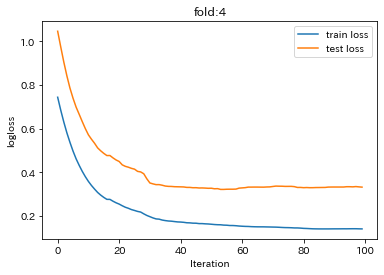

RMSE: [0.3255705321588003, 0.10067613248349422, 0.13926056239176185, 0.01946115135881871, 0.3144574249010471]
RMSE: 0.17988516065878443


In [ ]:
# 学習・推論
gkf = GroupKFold(n_splits=5)

groups = X_train_dropna["Genre"]

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': 'rmse',             # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'deterministic':True,         # 再現性確保用のパラメータ
          'force_row_wise':True,        # 再現性確保用のパラメータ
          'seed': SEED                   # シード値
          }

best_params, history = {}, []

cv_result = []

for fold, (train_index, test_index) in enumerate(gkf.split(X_train_dropna, y_train_dropna, groups)):
    X_train_gkf, X_test_gkf = X_train_dropna.iloc[train_index], X_train_dropna.iloc[test_index]
    y_train_gkf, y_test_gkf = y_train_dropna.iloc[train_index], y_train_dropna.iloc[test_index]

    # 学習、推論
    lgb_train = opt_lgb.Dataset(X_train_gkf, y_train_gkf)
    lgb_test = opt_lgb.Dataset(X_test_gkf, y_test_gkf, reference=lgb_train)

    lgb_results = {}                                    # 学習の履歴を入れる入物

    model = opt_lgb.LightGBMTuner(
                    params,                    # ハイパーパラメータをセット
                    train_set = lgb_train,              # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=100,              # 計算回数
                    early_stopping_rounds=50,         # アーリーストッピング設定
                    evals_result=lgb_results,
                    show_progress_bar = False,        # プログレスバーの非表示
                    verbose_eval=-1,                  # ログを最後の1つだけ表示
                    )  
    
    # 訓練の実施
    model.run()

    best_params = model.best_params
    best_model = model.get_best_booster()

    # 損失推移を表示
    loss_train = lgb_results['Train']['rmse']
    loss_test = lgb_results['Test']['rmse']   
    
    fig = plt.figure()
    
    plt.xlabel('Iteration')
    plt.ylabel('logloss')

    plt.title(f"fold:{fold}")
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='test loss')
    
    plt.legend()
    plt.show()

    # 推論
    y_pred = best_model.predict(X_test_gkf)

    # 評価
    rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)
    cv_result.append(rmse)

print("RMSE:", cv_result)
print("RMSE:", np.mean(cv_result))

## Stacking

### 1層目 各モデルの予測結果を集計

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from catboost import CatBoostRegressor

In [ ]:
models = {
    "ridge":Ridge(random_state=SEED),
    "lasso":Lasso(random_state=SEED),
    "linear":LinearRegression(),
    "elastic_net":ElasticNet(random_state=SEED),
    "svm":SVR(),
    "random_forest":RandomForestRegressor(random_state=SEED),
    "gradient":GradientBoostingRegressor(random_state=SEED),
    "catboost":CatBoostRegressor(random_state=SEED, 
                                 silent=True, # ログを非表示
                                 ),
    "xgboost":xgb.XGBRegressor(
        random_state=SEED,
        objective='reg:squarederror'
        ),
    "lightgbm":lgb.LGBMRegressor(random_state=SEED),
}

In [ ]:
gkf = GroupKFold(n_splits=5)
groups = X_train_dropna["Genre"]

cv_result_stck = {}
pred_df = pd.DataFrame()

for i, (model_name, model) in enumerate(models.items()):

    print(i, model)

    each_model_df = pd.DataFrame()
    each_model_result = []

    for train_index, test_index in gkf.split(X_train_dropna, y_train_dropna, groups):

        X_train_gkf, X_test_gkf = X_train_dropna.iloc[train_index], X_train_dropna.iloc[test_index]
        y_train_gkf, y_test_gkf = y_train_dropna.iloc[train_index], y_train_dropna.iloc[test_index]

        model.fit(X_train_gkf, y_train_gkf)
        y_pred = model.predict(X_test_gkf)

        tmp_df = pd.DataFrame(
                        [y_pred],
                        columns=test_index
                    )

        rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)
        each_model_result.append(rmse)
        each_model_df = pd.concat([each_model_df , tmp_df.T]) # 各KFold ごとの予測結果をDataFrameに縦に並べる

    cv_result_stck[model_name] = each_model_result # 各モデルのRMSEを集計
    each_model_df.columns = [model_name] # カラム名をモデル名に変更
    pred_df = pd.concat([pred_df, each_model_df.sort_index()], axis=1) # 予測結果集計用DataFrameに各モデルの予測結果をくっつける

0 Ridge(random_state=42)
1 Lasso(random_state=42)
2 LinearRegression()
3 ElasticNet(random_state=42)
4 SVR()
5 RandomForestRegressor(random_state=42)
6 GradientBoostingRegressor(random_state=42)
7 <catboost.core.CatBoostRegressor object at 0x7fb56b67b990>
8 XGBRegressor(objective='reg:squarederror', random_state=42)
9 LGBMRegressor(random_state=42)


In [ ]:
print(len(pred_df))

pred_df.head()

13294


,ridge,lasso,linear,elastic_net,svm,random_forest,gradient,catboost,xgboost,lightgbm
0,1.234173,0.354651,1.234278,0.354651,1.071052,1.1576,1.164830,1.199401,1.153994,1.161167
1,1.188873,0.358120,1.188951,0.358120,1.388058,6.3483,6.263937,6.303971,6.239638,6.003582
2,0.342531,0.387056,0.343087,0.387056,-0.023036,0.1100,0.110108,0.102123,0.112522,0.104825
3,-0.168588,0.397084,-0.167732,0.397084,0.052644,0.0200,0.020165,0.026559,0.020201,0.020066
4,-0.119594,0.387056,-0.121638,0.387056,0.058346,0.0100,0.010248,0.013421,0.010376,0.010143


In [ ]:
# 最も精度のよいモデルの名前を取得
best_model_name = ""
best_rmse = 9999.9999

for model_name, rmse in cv_result_stck.items():
    print(model_name, np.mean(rmse))
    if best_rmse > np.mean(rmse):
        best_rmse = np.mean(rmse)
        best_model_name = model_name

print()
print(f"Best model is {best_model_name}. Score is {best_rmse}")

ridge 0.6489204333565309
lasso 0.8005537342957698
linear 0.6488392612926843
elastic_net 0.8005537342957698
svm 0.5663063344963282
random_forest 0.04818682478759999
gradient 0.03310330843501304
catboost 0.21740859618848302
xgboost 0.03133802749741507
lightgbm 0.2028049151839622

Best model is xgboost. Score is 0.03133802749741507


### 2階層目 各モデルの予測結果をもとに予測

#### 最も良い精度の出たモデルを使う

In [ ]:
# 学習・推論
gkf = GroupKFold(n_splits=5)

groups = pred_df[best_model_name]

cv_result_stck_best_model = []

for train_index, test_index in gkf.split(pred_df, y_train_dropna, groups):

    X_train_gkf, X_test_gkf = pred_df.iloc[train_index], pred_df.iloc[test_index]
    y_train_gkf, y_test_gkf = y_train_dropna.iloc[train_index], y_train_dropna.iloc[test_index]

    # 学習、推論

    best_model = models[best_model_name]

    best_model.fit(X_train_gkf, y_train_gkf)
  
    y_pred = models[best_model_name].predict(X_test_gkf)

    rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)
    cv_result_stck_best_model.append(rmse)

print("RMSE:", cv_result_stck_best_model)
print("RMSE:", np.mean(cv_result_stck_best_model))

RMSE: [0.022684878211879107, 0.026195677643439347, 0.030031824905656715, 0.12628271844012434, 0.12488076559025357]
RMSE: 0.06601517295827061


#### Optuna + LightGBM を使う

[I 2021-12-14 12:11:19,087] A new study created in memory with name: no-name-dd0efd4e-7db3-4752-aa50-fbec0a2e5ae7


Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:19,355] Trial 0 finished with value: 0.05906909811006046 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.05906909811006046.


Early stopping, best iteration is:
[35]	Train's rmse: 0.134461	Test's rmse: 0.0590691
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:19,620] Trial 1 finished with value: 0.06126552454067979 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.05906909811006046.


Early stopping, best iteration is:
[33]	Train's rmse: 0.13429	Test's rmse: 0.0612655
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:19,909] Trial 2 finished with value: 0.060104857480787865 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.05906909811006046.


Early stopping, best iteration is:
[33]	Train's rmse: 0.134508	Test's rmse: 0.0601049
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:20,218] Trial 3 finished with value: 0.0612337586775578 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.05906909811006046.


Early stopping, best iteration is:
[32]	Train's rmse: 0.13406	Test's rmse: 0.0612338
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:20,475] Trial 4 finished with value: 0.059975117035573206 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.05906909811006046.


Early stopping, best iteration is:
[36]	Train's rmse: 0.13391	Test's rmse: 0.0599751
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:20,771] Trial 5 finished with value: 0.06148709366527587 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.05906909811006046.


Early stopping, best iteration is:
[32]	Train's rmse: 0.134249	Test's rmse: 0.0614871
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:21,063] Trial 6 finished with value: 0.06097519640690137 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.05906909811006046.


Early stopping, best iteration is:
[32]	Train's rmse: 0.134519	Test's rmse: 0.0609752
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:21,510] Trial 7 finished with value: 0.05911865724814318 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.05911865724814318.


Early stopping, best iteration is:
[35]	Train's rmse: 0.134466	Test's rmse: 0.0591187
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:22,245] Trial 8 finished with value: 0.059112399359361065 and parameters: {'num_leaves': 244}. Best is trial 8 with value: 0.059112399359361065.


Early stopping, best iteration is:
[35]	Train's rmse: 0.134465	Test's rmse: 0.0591124
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:22,873] Trial 9 finished with value: 0.059114674054538525 and parameters: {'num_leaves': 188}. Best is trial 8 with value: 0.059112399359361065.


Early stopping, best iteration is:
[35]	Train's rmse: 0.134465	Test's rmse: 0.0591147
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:23,434] Trial 10 finished with value: 0.05911524799124656 and parameters: {'num_leaves': 154}. Best is trial 8 with value: 0.059112399359361065.


Early stopping, best iteration is:
[35]	Train's rmse: 0.134465	Test's rmse: 0.0591152
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:23,730] Trial 11 finished with value: 0.05902047205110994 and parameters: {'num_leaves': 41}. Best is trial 11 with value: 0.05902047205110994.


Early stopping, best iteration is:
[35]	Train's rmse: 0.134443	Test's rmse: 0.0590205
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:24,023] Trial 12 finished with value: 0.05902047205110994 and parameters: {'num_leaves': 41}. Best is trial 11 with value: 0.05902047205110994.


Early stopping, best iteration is:
[35]	Train's rmse: 0.134443	Test's rmse: 0.0590205
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:24,230] Trial 13 finished with value: 0.059220692178014185 and parameters: {'num_leaves': 16}. Best is trial 11 with value: 0.05902047205110994.


Early stopping, best iteration is:
[35]	Train's rmse: 0.134599	Test's rmse: 0.0592207
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:24,941] Trial 14 finished with value: 0.059112296241644074 and parameters: {'num_leaves': 222}. Best is trial 11 with value: 0.05902047205110994.


Early stopping, best iteration is:
[35]	Train's rmse: 0.134465	Test's rmse: 0.0591123
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:25,488] Trial 15 finished with value: 0.059115043155357455 and parameters: {'num_leaves': 155}. Best is trial 11 with value: 0.05902047205110994.


Early stopping, best iteration is:
[35]	Train's rmse: 0.134465	Test's rmse: 0.059115
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:26,089] Trial 16 finished with value: 0.05911376550465192 and parameters: {'num_leaves': 182}. Best is trial 11 with value: 0.05902047205110994.


Early stopping, best iteration is:
[35]	Train's rmse: 0.134465	Test's rmse: 0.0591138
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:26,494] Trial 17 finished with value: 0.05905837400450191 and parameters: {'num_leaves': 81}. Best is trial 11 with value: 0.05902047205110994.
[I 2021-12-14 12:11:26,594] Trial 18 finished with value: 0.06044941836487826 and parameters: {'num_leaves': 2}. Best is trial 11 with value: 0.05902047205110994.


Early stopping, best iteration is:
[35]	Train's rmse: 0.134467	Test's rmse: 0.0590584
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136801	Test's rmse: 0.0604494
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:26,928] Trial 19 finished with value: 0.059002317923807376 and parameters: {'num_leaves': 56}. Best is trial 19 with value: 0.059002317923807376.


Early stopping, best iteration is:
[35]	Train's rmse: 0.134443	Test's rmse: 0.0590023
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:27,292] Trial 20 finished with value: 0.05904861519560888 and parameters: {'num_leaves': 65}. Best is trial 19 with value: 0.059002317923807376.


Early stopping, best iteration is:
[35]	Train's rmse: 0.134468	Test's rmse: 0.0590486
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:27,746] Trial 21 finished with value: 0.059121909245259285 and parameters: {'num_leaves': 107}. Best is trial 19 with value: 0.059002317923807376.


Early stopping, best iteration is:
[35]	Train's rmse: 0.134465	Test's rmse: 0.0591219
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:28,062] Trial 22 finished with value: 0.05901997337685213 and parameters: {'num_leaves': 46}. Best is trial 19 with value: 0.059002317923807376.


Early stopping, best iteration is:
[35]	Train's rmse: 0.134463	Test's rmse: 0.05902
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:28,378] Trial 23 finished with value: 0.05902182749041818 and parameters: {'num_leaves': 48}. Best is trial 19 with value: 0.059002317923807376.


Early stopping, best iteration is:
[35]	Train's rmse: 0.134461	Test's rmse: 0.0590218
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:28,873] Trial 24 finished with value: 0.05911159152697513 and parameters: {'num_leaves': 122}. Best is trial 19 with value: 0.059002317923807376.


Early stopping, best iteration is:
[35]	Train's rmse: 0.134465	Test's rmse: 0.0591116
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:29,125] Trial 25 finished with value: 0.05908274990263757 and parameters: {'num_leaves': 26}. Best is trial 19 with value: 0.059002317923807376.


Early stopping, best iteration is:
[35]	Train's rmse: 0.134464	Test's rmse: 0.0590827
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:29,504] Trial 26 finished with value: 0.05905386444954572 and parameters: {'num_leaves': 72}. Best is trial 19 with value: 0.059002317923807376.


Early stopping, best iteration is:
[35]	Train's rmse: 0.134468	Test's rmse: 0.0590539
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:30,028] Trial 27 finished with value: 0.1005837109923725 and parameters: {'bagging_fraction': 0.624724071308792, 'bagging_freq': 7}. Best is trial 27 with value: 0.1005837109923725.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.164789	Test's rmse: 0.100584
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:30,540] Trial 28 finished with value: 0.07434364987503195 and parameters: {'bagging_fraction': 0.8391963650875751, 'bagging_freq': 5}. Best is trial 28 with value: 0.07434364987503195.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135826	Test's rmse: 0.0743436
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:31,045] Trial 29 finished with value: 0.13543931184337907 and parameters: {'bagging_fraction': 0.49361118426561795, 'bagging_freq': 2}. Best is trial 28 with value: 0.07434364987503195.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.183985	Test's rmse: 0.135439
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:31,561] Trial 30 finished with value: 0.14362069910982578 and parameters: {'bagging_fraction': 0.4348501673009778, 'bagging_freq': 7}. Best is trial 28 with value: 0.07434364987503195.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.189636	Test's rmse: 0.143621
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:32,077] Trial 31 finished with value: 0.08046124388831864 and parameters: {'bagging_fraction': 0.7606690070465265, 'bagging_freq': 5}. Best is trial 28 with value: 0.07434364987503195.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14389	Test's rmse: 0.0804612
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:32,584] Trial 32 finished with value: 0.1475867798632325 and parameters: {'bagging_fraction': 0.41235069657750206, 'bagging_freq': 7}. Best is trial 28 with value: 0.07434364987503195.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.198283	Test's rmse: 0.147587
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:33,017] Trial 33 finished with value: 0.05862979458232921 and parameters: {'bagging_fraction': 0.8994655844810855, 'bagging_freq': 2}. Best is trial 33 with value: 0.05862979458232921.


Early stopping, best iteration is:
[37]	Train's rmse: 0.136279	Test's rmse: 0.0586298
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:33,533] Trial 34 finished with value: 0.135289045828673 and parameters: {'bagging_fraction': 0.5090949803244422, 'bagging_freq': 2}. Best is trial 33 with value: 0.05862979458232921.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182265	Test's rmse: 0.135289
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:34,032] Trial 35 finished with value: 0.1110556257157886 and parameters: {'bagging_fraction': 0.5825453457760269, 'bagging_freq': 4}. Best is trial 33 with value: 0.05862979458232921.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.171372	Test's rmse: 0.111056
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:34,531] Trial 36 finished with value: 0.08552490478880495 and parameters: {'bagging_fraction': 0.6591670111857015, 'bagging_freq': 3}. Best is trial 33 with value: 0.05862979458232921.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.155486	Test's rmse: 0.0855249
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:34,956] Trial 37 finished with value: 0.05805711485632808 and parameters: {'feature_fraction': 0.484}. Best is trial 37 with value: 0.05805711485632808.


Early stopping, best iteration is:
[37]	Train's rmse: 0.138332	Test's rmse: 0.0580571
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:35,406] Trial 38 finished with value: 0.05862979458232921 and parameters: {'feature_fraction': 0.5479999999999999}. Best is trial 37 with value: 0.05805711485632808.


Early stopping, best iteration is:
[37]	Train's rmse: 0.136279	Test's rmse: 0.0586298
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:35,825] Trial 39 finished with value: 0.05805711485632808 and parameters: {'feature_fraction': 0.45199999999999996}. Best is trial 37 with value: 0.05805711485632808.


Early stopping, best iteration is:
[37]	Train's rmse: 0.138332	Test's rmse: 0.0580571
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:36,239] Trial 40 finished with value: 0.05805711485632808 and parameters: {'feature_fraction': 0.42}. Best is trial 37 with value: 0.05805711485632808.


Early stopping, best iteration is:
[37]	Train's rmse: 0.138332	Test's rmse: 0.0580571
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:36,677] Trial 41 finished with value: 0.05862979458232921 and parameters: {'feature_fraction': 0.58}. Best is trial 37 with value: 0.05805711485632808.


Early stopping, best iteration is:
[37]	Train's rmse: 0.136279	Test's rmse: 0.0586298
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:37,104] Trial 42 finished with value: 0.05862979458232921 and parameters: {'feature_fraction': 0.516}. Best is trial 37 with value: 0.05805711485632808.


Early stopping, best iteration is:
[37]	Train's rmse: 0.136279	Test's rmse: 0.0586298
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:37,575] Trial 43 finished with value: 0.06122954130908556 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403}. Best is trial 43 with value: 0.06122954130908556.


Early stopping, best iteration is:
[48]	Train's rmse: 0.139001	Test's rmse: 0.0612295
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:37,969] Trial 44 finished with value: 0.058088605883033134 and parameters: {'lambda_l1': 0.038720902953704193, 'lambda_l2': 0.0024430162614261413}. Best is trial 44 with value: 0.058088605883033134.


Early stopping, best iteration is:
[37]	Train's rmse: 0.138386	Test's rmse: 0.0580886
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:38,379] Trial 45 finished with value: 0.05805711576148707 and parameters: {'lambda_l1': 2.5361081166471375e-07, 'lambda_l2': 2.5348407664333426e-07}. Best is trial 45 with value: 0.05805711576148707.


Early stopping, best iteration is:
[37]	Train's rmse: 0.138332	Test's rmse: 0.0580571
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:38,812] Trial 46 finished with value: 0.05834190280691217 and parameters: {'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893}. Best is trial 45 with value: 0.05805711576148707.


Early stopping, best iteration is:
[39]	Train's rmse: 0.13779	Test's rmse: 0.0583419
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:39,221] Trial 47 finished with value: 0.05807271336437878 and parameters: {'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682}. Best is trial 45 with value: 0.05805711576148707.


Early stopping, best iteration is:
[37]	Train's rmse: 0.138354	Test's rmse: 0.0580727
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:39,688] Trial 48 finished with value: 0.06006476719496065 and parameters: {'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285}. Best is trial 45 with value: 0.05805711576148707.


Early stopping, best iteration is:
[48]	Train's rmse: 0.141255	Test's rmse: 0.0600648
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:39,977] Trial 49 finished with value: 0.05836293310605148 and parameters: {'lambda_l1': 0.31044435499483225, 'lambda_l2': 8.148018307012941e-07}. Best is trial 45 with value: 0.05805711576148707.


Early stopping, best iteration is:
[37]	Train's rmse: 0.138593	Test's rmse: 0.0583629
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:40,392] Trial 50 finished with value: 0.058057116399531226 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07}. Best is trial 45 with value: 0.05805711576148707.


Early stopping, best iteration is:
[37]	Train's rmse: 0.138332	Test's rmse: 0.0580571
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:40,819] Trial 51 finished with value: 0.058063885500373044 and parameters: {'lambda_l1': 5.472429642032198e-06, 'lambda_l2': 0.00052821153945323}. Best is trial 45 with value: 0.05805711576148707.


Early stopping, best iteration is:
[37]	Train's rmse: 0.138333	Test's rmse: 0.0580639
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:41,238] Trial 52 finished with value: 0.058062845017523575 and parameters: {'lambda_l1': 7.71800699380605e-05, 'lambda_l2': 4.17890272377219e-06}. Best is trial 45 with value: 0.05805711576148707.


Early stopping, best iteration is:
[37]	Train's rmse: 0.138333	Test's rmse: 0.0580628
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:41,466] Trial 53 finished with value: 0.06090423495134412 and parameters: {'lambda_l1': 3.207959657544482, 'lambda_l2': 1.1323342574941946e-08}. Best is trial 45 with value: 0.05805711576148707.


Early stopping, best iteration is:
[40]	Train's rmse: 0.137805	Test's rmse: 0.0609042
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:41,881] Trial 54 finished with value: 0.058062514957249504 and parameters: {'lambda_l1': 8.739208840790941e-07, 'lambda_l2': 1.99371629285331e-06}. Best is trial 45 with value: 0.05805711576148707.


Early stopping, best iteration is:
[37]	Train's rmse: 0.138333	Test's rmse: 0.0580625
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:42,300] Trial 55 finished with value: 0.058057115707643644 and parameters: {'lambda_l1': 3.2956792945849545e-07, 'lambda_l2': 2.2311398834761413e-08}. Best is trial 55 with value: 0.058057115707643644.


Early stopping, best iteration is:
[37]	Train's rmse: 0.138332	Test's rmse: 0.0580571
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:42,714] Trial 56 finished with value: 0.05805858934716006 and parameters: {'lambda_l1': 0.0008421907750901968, 'lambda_l2': 1.2702524155028834e-08}. Best is trial 55 with value: 0.058057115707643644.


Early stopping, best iteration is:
[37]	Train's rmse: 0.138334	Test's rmse: 0.0580586
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:43,138] Trial 57 finished with value: 0.05806253856152234 and parameters: {'lambda_l1': 3.447615183683311e-07, 'lambda_l2': 2.6087844118276602e-05}. Best is trial 55 with value: 0.058057115707643644.


Early stopping, best iteration is:
[37]	Train's rmse: 0.138333	Test's rmse: 0.0580625
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:43,557] Trial 58 finished with value: 0.058062522570242525 and parameters: {'lambda_l1': 4.895525573655169e-06, 'lambda_l2': 1.3153049473274364e-07}. Best is trial 55 with value: 0.058057115707643644.


Early stopping, best iteration is:
[37]	Train's rmse: 0.138333	Test's rmse: 0.0580625
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:43,977] Trial 59 finished with value: 0.05806254806941871 and parameters: {'lambda_l1': 8.888685965689552e-08, 'lambda_l2': 3.59424753355417e-05}. Best is trial 55 with value: 0.058057115707643644.


Early stopping, best iteration is:
[37]	Train's rmse: 0.138333	Test's rmse: 0.0580625
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:44,400] Trial 60 finished with value: 0.05805385016480083 and parameters: {'lambda_l1': 0.00013207817698280088, 'lambda_l2': 6.182028633393764e-08}. Best is trial 60 with value: 0.05805385016480083.


Early stopping, best iteration is:
[37]	Train's rmse: 0.138335	Test's rmse: 0.0580539
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:44,825] Trial 61 finished with value: 0.058074603668521955 and parameters: {'lambda_l1': 0.006619403883408229, 'lambda_l2': 4.4867592289699433e-08}. Best is trial 60 with value: 0.05805385016480083.


Early stopping, best iteration is:
[37]	Train's rmse: 0.138355	Test's rmse: 0.0580746
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:45,252] Trial 62 finished with value: 0.058054314557217254 and parameters: {'lambda_l1': 0.00025810516640876845, 'lambda_l2': 1.7050148532160947e-05}. Best is trial 60 with value: 0.05805385016480083.


Early stopping, best iteration is:
[37]	Train's rmse: 0.138336	Test's rmse: 0.0580543
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:45,635] Trial 63 finished with value: 0.052679342271553596 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.052679342271553596.


Early stopping, best iteration is:
[36]	Train's rmse: 0.0567964	Test's rmse: 0.0526793
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:45,994] Trial 64 finished with value: 0.05305393904272182 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.052679342271553596.


Early stopping, best iteration is:
[30]	Train's rmse: 0.090535	Test's rmse: 0.0530539
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:46,511] Trial 65 finished with value: 0.08214753461495505 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.052679342271553596.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.151381	Test's rmse: 0.0821475
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:47,057] Trial 66 finished with value: 0.15472880029174355 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.052679342271553596.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.221904	Test's rmse: 0.154729
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:47,620] Trial 67 finished with value: 0.22513712350277576 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.052679342271553596.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.282398	Test's rmse: 0.225137


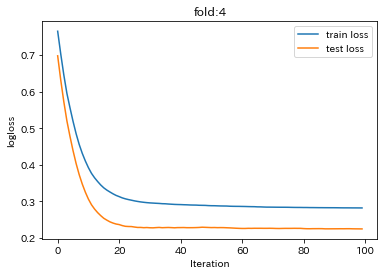

[I 2021-12-14 12:11:47,804] A new study created in memory with name: no-name-6e70cf41-91fb-4d8e-8c24-a83eab003721


Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:48,139] Trial 0 finished with value: 0.025040268390335334 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.025040268390335334.


Early stopping, best iteration is:
[46]	Train's rmse: 0.12506	Test's rmse: 0.0250403
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:48,441] Trial 1 finished with value: 0.02229233698830732 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 0.02229233698830732.


Early stopping, best iteration is:
[38]	Train's rmse: 0.126555	Test's rmse: 0.0222923
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:48,756] Trial 2 finished with value: 0.023489889546843112 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 0.02229233698830732.


Early stopping, best iteration is:
[38]	Train's rmse: 0.125938	Test's rmse: 0.0234899
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:49,054] Trial 3 finished with value: 0.024061342040078457 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 0.02229233698830732.


Early stopping, best iteration is:
[43]	Train's rmse: 0.128515	Test's rmse: 0.0240613
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:49,359] Trial 4 finished with value: 0.023645218559607106 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.02229233698830732.


Early stopping, best iteration is:
[46]	Train's rmse: 0.125728	Test's rmse: 0.0236452
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:49,663] Trial 5 finished with value: 0.03201789190664106 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 0.02229233698830732.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.122171	Test's rmse: 0.0320179
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:49,999] Trial 6 finished with value: 0.02394556891971973 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 0.02229233698830732.


Early stopping, best iteration is:
[38]	Train's rmse: 0.125631	Test's rmse: 0.0239456
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:50,529] Trial 7 finished with value: 0.023662045648052483 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.023662045648052483.


Early stopping, best iteration is:
[38]	Train's rmse: 0.126002	Test's rmse: 0.023662
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:51,470] Trial 8 finished with value: 0.02365852276287867 and parameters: {'num_leaves': 244}. Best is trial 8 with value: 0.02365852276287867.


Early stopping, best iteration is:
[38]	Train's rmse: 0.126045	Test's rmse: 0.0236585
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:52,257] Trial 9 finished with value: 0.02365441779652095 and parameters: {'num_leaves': 188}. Best is trial 9 with value: 0.02365441779652095.


Early stopping, best iteration is:
[38]	Train's rmse: 0.126045	Test's rmse: 0.0236544
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:52,927] Trial 10 finished with value: 0.023645552533202167 and parameters: {'num_leaves': 154}. Best is trial 10 with value: 0.023645552533202167.


Early stopping, best iteration is:
[38]	Train's rmse: 0.126048	Test's rmse: 0.0236456
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:53,271] Trial 11 finished with value: 0.023649714052866325 and parameters: {'num_leaves': 41}. Best is trial 10 with value: 0.023645552533202167.


Early stopping, best iteration is:
[38]	Train's rmse: 0.126029	Test's rmse: 0.0236497
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:53,606] Trial 12 finished with value: 0.023649714052866325 and parameters: {'num_leaves': 41}. Best is trial 10 with value: 0.023645552533202167.


Early stopping, best iteration is:
[38]	Train's rmse: 0.126029	Test's rmse: 0.0236497
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:53,834] Trial 13 finished with value: 0.022685778923661942 and parameters: {'num_leaves': 16}. Best is trial 13 with value: 0.022685778923661942.


Early stopping, best iteration is:
[38]	Train's rmse: 0.126343	Test's rmse: 0.0226858
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:54,708] Trial 14 finished with value: 0.02365775426564423 and parameters: {'num_leaves': 222}. Best is trial 13 with value: 0.022685778923661942.


Early stopping, best iteration is:
[38]	Train's rmse: 0.126045	Test's rmse: 0.0236578
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:55,401] Trial 15 finished with value: 0.02364226845037065 and parameters: {'num_leaves': 155}. Best is trial 13 with value: 0.022685778923661942.


Early stopping, best iteration is:
[38]	Train's rmse: 0.126048	Test's rmse: 0.0236423
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:56,184] Trial 16 finished with value: 0.023653624619276257 and parameters: {'num_leaves': 182}. Best is trial 13 with value: 0.022685778923661942.
[I 2021-12-14 12:11:56,343] Trial 17 finished with value: 0.023696683602042724 and parameters: {'num_leaves': 7}. Best is trial 13 with value: 0.022685778923661942.


Early stopping, best iteration is:
[38]	Train's rmse: 0.126045	Test's rmse: 0.0236536
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[44]	Train's rmse: 0.125051	Test's rmse: 0.0236967
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:56,896] Trial 18 finished with value: 0.02366037848657745 and parameters: {'num_leaves': 104}. Best is trial 13 with value: 0.022685778923661942.


Early stopping, best iteration is:
[38]	Train's rmse: 0.126045	Test's rmse: 0.0236604
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:57,509] Trial 19 finished with value: 0.023637071541185165 and parameters: {'num_leaves': 128}. Best is trial 13 with value: 0.022685778923661942.


Early stopping, best iteration is:
[38]	Train's rmse: 0.126048	Test's rmse: 0.0236371
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:57,964] Trial 20 finished with value: 0.023653883343965162 and parameters: {'num_leaves': 76}. Best is trial 13 with value: 0.022685778923661942.
[I 2021-12-14 12:11:58,113] Trial 21 finished with value: 0.024560459325906187 and parameters: {'num_leaves': 5}. Best is trial 13 with value: 0.022685778923661942.


Early stopping, best iteration is:
[38]	Train's rmse: 0.126002	Test's rmse: 0.0236539
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[47]	Train's rmse: 0.126753	Test's rmse: 0.0245605
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:58,510] Trial 22 finished with value: 0.02355000480992408 and parameters: {'num_leaves': 56}. Best is trial 13 with value: 0.022685778923661942.


Early stopping, best iteration is:
[38]	Train's rmse: 0.126004	Test's rmse: 0.02355
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:58,901] Trial 23 finished with value: 0.02355000480992408 and parameters: {'num_leaves': 56}. Best is trial 13 with value: 0.022685778923661942.


Early stopping, best iteration is:
[38]	Train's rmse: 0.126004	Test's rmse: 0.02355
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:59,225] Trial 24 finished with value: 0.023642459544842814 and parameters: {'num_leaves': 33}. Best is trial 13 with value: 0.022685778923661942.


Early stopping, best iteration is:
[38]	Train's rmse: 0.126012	Test's rmse: 0.0236425
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:11:59,664] Trial 25 finished with value: 0.023664242177358342 and parameters: {'num_leaves': 69}. Best is trial 13 with value: 0.022685778923661942.


Early stopping, best iteration is:
[38]	Train's rmse: 0.125998	Test's rmse: 0.0236642
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:00,226] Trial 26 finished with value: 0.023645484508515103 and parameters: {'num_leaves': 98}. Best is trial 13 with value: 0.022685778923661942.


Early stopping, best iteration is:
[38]	Train's rmse: 0.126002	Test's rmse: 0.0236455
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:00,662] Trial 27 finished with value: 0.06928488065870866 and parameters: {'bagging_fraction': 0.624724071308792, 'bagging_freq': 7}. Best is trial 27 with value: 0.06928488065870866.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.151942	Test's rmse: 0.0692849
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:01,097] Trial 28 finished with value: 0.050195879023263806 and parameters: {'bagging_fraction': 0.8391963650875751, 'bagging_freq': 5}. Best is trial 28 with value: 0.050195879023263806.


Did not meet early stopping. Best iteration is:
[96]	Train's rmse: 0.128854	Test's rmse: 0.0501959
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:01,453] Trial 29 finished with value: 0.08757269334605308 and parameters: {'bagging_fraction': 0.49361118426561795, 'bagging_freq': 2}. Best is trial 28 with value: 0.050195879023263806.


Early stopping, best iteration is:
[36]	Train's rmse: 0.19187	Test's rmse: 0.0875727
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:01,842] Trial 30 finished with value: 0.10786810988504812 and parameters: {'bagging_fraction': 0.4348501673009778, 'bagging_freq': 7}. Best is trial 28 with value: 0.050195879023263806.


Early stopping, best iteration is:
[43]	Train's rmse: 0.209974	Test's rmse: 0.107868
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:02,302] Trial 31 finished with value: 0.05169930830281689 and parameters: {'bagging_fraction': 0.7606690070465265, 'bagging_freq': 5}. Best is trial 28 with value: 0.050195879023263806.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137115	Test's rmse: 0.0516993
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:02,687] Trial 32 finished with value: 0.10526160143742253 and parameters: {'bagging_fraction': 0.41235069657750206, 'bagging_freq': 7}. Best is trial 28 with value: 0.050195879023263806.


Early stopping, best iteration is:
[42]	Train's rmse: 0.210979	Test's rmse: 0.105262
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:03,145] Trial 33 finished with value: 0.04128946827171088 and parameters: {'bagging_fraction': 0.8994655844810855, 'bagging_freq': 2}. Best is trial 33 with value: 0.04128946827171088.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12332	Test's rmse: 0.0412895
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:03,500] Trial 34 finished with value: 0.0838798790394459 and parameters: {'bagging_fraction': 0.5090949803244422, 'bagging_freq': 2}. Best is trial 33 with value: 0.04128946827171088.


Early stopping, best iteration is:
[36]	Train's rmse: 0.186016	Test's rmse: 0.0838799
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:03,933] Trial 35 finished with value: 0.0668364724713338 and parameters: {'bagging_fraction': 0.5825453457760269, 'bagging_freq': 4}. Best is trial 33 with value: 0.04128946827171088.


Did not meet early stopping. Best iteration is:
[96]	Train's rmse: 0.164164	Test's rmse: 0.0668365
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:04,375] Trial 36 finished with value: 0.0711876931965441 and parameters: {'bagging_fraction': 0.6591670111857015, 'bagging_freq': 3}. Best is trial 33 with value: 0.04128946827171088.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141705	Test's rmse: 0.0711877
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:04,686] Trial 37 finished with value: 0.02229233698830732 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 37 with value: 0.02229233698830732.


Early stopping, best iteration is:
[38]	Train's rmse: 0.126555	Test's rmse: 0.0222923
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:05,003] Trial 38 finished with value: 0.025040268390335334 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 37 with value: 0.02229233698830732.


Early stopping, best iteration is:
[46]	Train's rmse: 0.12506	Test's rmse: 0.0250403
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:05,313] Trial 39 finished with value: 0.02229233698830732 and parameters: {'feature_fraction': 0.88}. Best is trial 37 with value: 0.02229233698830732.


Early stopping, best iteration is:
[38]	Train's rmse: 0.126555	Test's rmse: 0.0222923
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:05,629] Trial 40 finished with value: 0.025040268390335334 and parameters: {'feature_fraction': 0.784}. Best is trial 37 with value: 0.02229233698830732.


Early stopping, best iteration is:
[46]	Train's rmse: 0.12506	Test's rmse: 0.0250403
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:05,931] Trial 41 finished with value: 0.02229233698830732 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 37 with value: 0.02229233698830732.


Early stopping, best iteration is:
[38]	Train's rmse: 0.126555	Test's rmse: 0.0222923
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:06,263] Trial 42 finished with value: 0.025040268390335334 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 37 with value: 0.02229233698830732.


Early stopping, best iteration is:
[46]	Train's rmse: 0.12506	Test's rmse: 0.0250403
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:06,607] Trial 43 finished with value: 0.019083936606909567 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403}. Best is trial 43 with value: 0.019083936606909567.


Early stopping, best iteration is:
[43]	Train's rmse: 0.128394	Test's rmse: 0.0190839
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:06,911] Trial 44 finished with value: 0.0226252142771108 and parameters: {'lambda_l1': 0.038720902953704193, 'lambda_l2': 0.0024430162614261413}. Best is trial 43 with value: 0.019083936606909567.


Early stopping, best iteration is:
[38]	Train's rmse: 0.126353	Test's rmse: 0.0226252
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:07,214] Trial 45 finished with value: 0.022292337684753007 and parameters: {'lambda_l1': 2.5361081166471375e-07, 'lambda_l2': 2.5348407664333426e-07}. Best is trial 43 with value: 0.019083936606909567.


Early stopping, best iteration is:
[38]	Train's rmse: 0.126555	Test's rmse: 0.0222923
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:07,532] Trial 46 finished with value: 0.02212846565891091 and parameters: {'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893}. Best is trial 43 with value: 0.019083936606909567.


Early stopping, best iteration is:
[38]	Train's rmse: 0.126944	Test's rmse: 0.0221285
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:07,834] Trial 47 finished with value: 0.02366341686799767 and parameters: {'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682}. Best is trial 43 with value: 0.019083936606909567.


Early stopping, best iteration is:
[38]	Train's rmse: 0.126061	Test's rmse: 0.0236634
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:08,168] Trial 48 finished with value: 0.0215011431400123 and parameters: {'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285}. Best is trial 43 with value: 0.019083936606909567.


Early stopping, best iteration is:
[43]	Train's rmse: 0.130069	Test's rmse: 0.0215011
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:08,440] Trial 49 finished with value: 0.023224701766303892 and parameters: {'lambda_l1': 0.31044435499483225, 'lambda_l2': 8.148018307012941e-07}. Best is trial 43 with value: 0.019083936606909567.


Early stopping, best iteration is:
[38]	Train's rmse: 0.12658	Test's rmse: 0.0232247
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:08,752] Trial 50 finished with value: 0.02229233809169045 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07}. Best is trial 43 with value: 0.019083936606909567.


Early stopping, best iteration is:
[38]	Train's rmse: 0.126555	Test's rmse: 0.0222923
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:09,065] Trial 51 finished with value: 0.02229277604555763 and parameters: {'lambda_l1': 5.472429642032198e-06, 'lambda_l2': 0.00052821153945323}. Best is trial 43 with value: 0.019083936606909567.


Early stopping, best iteration is:
[38]	Train's rmse: 0.126555	Test's rmse: 0.0222928
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:09,380] Trial 52 finished with value: 0.022292481434566323 and parameters: {'lambda_l1': 7.71800699380605e-05, 'lambda_l2': 4.17890272377219e-06}. Best is trial 43 with value: 0.019083936606909567.


Early stopping, best iteration is:
[38]	Train's rmse: 0.126555	Test's rmse: 0.0222925
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:09,608] Trial 53 finished with value: 0.02333607730178136 and parameters: {'lambda_l1': 3.207959657544482, 'lambda_l2': 0.08759673038878969}. Best is trial 43 with value: 0.019083936606909567.


Early stopping, best iteration is:
[49]	Train's rmse: 0.126059	Test's rmse: 0.0233361
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:09,925] Trial 54 finished with value: 0.020012804159074304 and parameters: {'lambda_l1': 1.1692997958212103e-08, 'lambda_l2': 3.9472261531899844}. Best is trial 43 with value: 0.019083936606909567.


Early stopping, best iteration is:
[41]	Train's rmse: 0.129768	Test's rmse: 0.0200128
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:10,247] Trial 55 finished with value: 0.02106353422817382 and parameters: {'lambda_l1': 5.844078044738684e-05, 'lambda_l2': 2.417987765356211}. Best is trial 43 with value: 0.019083936606909567.


Early stopping, best iteration is:
[39]	Train's rmse: 0.128404	Test's rmse: 0.0210635
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:10,560] Trial 56 finished with value: 0.023571311363372194 and parameters: {'lambda_l1': 0.0016509874021187025, 'lambda_l2': 3.404677878190547e-05}. Best is trial 43 with value: 0.019083936606909567.


Early stopping, best iteration is:
[38]	Train's rmse: 0.126005	Test's rmse: 0.0235713
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:10,864] Trial 57 finished with value: 0.02229234449548435 and parameters: {'lambda_l1': 4.150019626406837e-06, 'lambda_l2': 1.3139855587432983e-08}. Best is trial 43 with value: 0.019083936606909567.


Early stopping, best iteration is:
[38]	Train's rmse: 0.126555	Test's rmse: 0.0222923
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:11,180] Trial 58 finished with value: 0.023541048139881504 and parameters: {'lambda_l1': 3.3639426888455315e-06, 'lambda_l2': 0.09582202435248795}. Best is trial 43 with value: 0.019083936606909567.


Early stopping, best iteration is:
[38]	Train's rmse: 0.126027	Test's rmse: 0.023541
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:11,526] Trial 59 finished with value: 0.017518370105894306 and parameters: {'lambda_l1': 1.505434741802647e-07, 'lambda_l2': 8.462570930314385}. Best is trial 59 with value: 0.017518370105894306.


Early stopping, best iteration is:
[47]	Train's rmse: 0.130489	Test's rmse: 0.0175184
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:11,833] Trial 60 finished with value: 0.02355217663667245 and parameters: {'lambda_l1': 2.1401082380677553e-07, 'lambda_l2': 0.005403988423797122}. Best is trial 59 with value: 0.017518370105894306.


Early stopping, best iteration is:
[38]	Train's rmse: 0.126035	Test's rmse: 0.0235522
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:12,167] Trial 61 finished with value: 0.02372780278696055 and parameters: {'lambda_l1': 6.982496886163923e-05, 'lambda_l2': 0.34796393293612976}. Best is trial 59 with value: 0.017518370105894306.


Early stopping, best iteration is:
[43]	Train's rmse: 0.124164	Test's rmse: 0.0237278
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:12,475] Trial 62 finished with value: 0.02352654530734544 and parameters: {'lambda_l1': 0.0006218468346558032, 'lambda_l2': 4.437788155166033e-05}. Best is trial 59 with value: 0.017518370105894306.


Early stopping, best iteration is:
[38]	Train's rmse: 0.126047	Test's rmse: 0.0235265
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:12,767] Trial 63 finished with value: 0.11616007670061468 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.11616007670061468.


Early stopping, best iteration is:
[28]	Train's rmse: 0.235736	Test's rmse: 0.11616
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:13,053] Trial 64 finished with value: 0.14936721144467416 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.11616007670061468.


Early stopping, best iteration is:
[26]	Train's rmse: 0.303267	Test's rmse: 0.149367
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:13,391] Trial 65 finished with value: 0.013128277345649007 and parameters: {'min_child_samples': 5}. Best is trial 65 with value: 0.013128277345649007.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0488586	Test's rmse: 0.0131283
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:13,714] Trial 66 finished with value: 0.01099759137638774 and parameters: {'min_child_samples': 10}. Best is trial 66 with value: 0.01099759137638774.


Early stopping, best iteration is:
[45]	Train's rmse: 0.0744105	Test's rmse: 0.0109976
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:14,035] Trial 67 finished with value: 0.059730490691281224 and parameters: {'min_child_samples': 25}. Best is trial 66 with value: 0.01099759137638774.


Early stopping, best iteration is:
[42]	Train's rmse: 0.154544	Test's rmse: 0.0597305


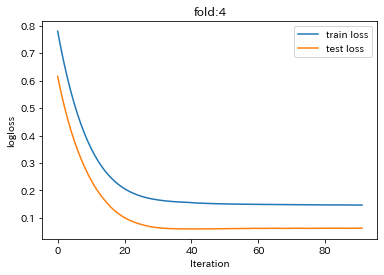

[I 2021-12-14 12:12:14,239] A new study created in memory with name: no-name-a6ae3b70-e1b1-4a3d-a194-934c2f503250
[I 2021-12-14 12:12:14,489] Trial 0 finished with value: 0.12031787105786197 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.12031787105786197.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[30]	Train's rmse: 0.148904	Test's rmse: 0.120318


[I 2021-12-14 12:12:14,720] Trial 1 finished with value: 0.1195119143449104 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 0.1195119143449104.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[29]	Train's rmse: 0.150466	Test's rmse: 0.119512
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:15,023] Trial 2 finished with value: 0.11863941164149543 and parameters: {'feature_fraction': 1.0}. Best is trial 2 with value: 0.11863941164149543.


Early stopping, best iteration is:
[30]	Train's rmse: 0.147125	Test's rmse: 0.118639
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:15,279] Trial 3 finished with value: 0.11950412087754687 and parameters: {'feature_fraction': 0.6}. Best is trial 2 with value: 0.11863941164149543.


Early stopping, best iteration is:
[29]	Train's rmse: 0.149578	Test's rmse: 0.119504
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:15,574] Trial 4 finished with value: 0.11848884178690959 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 4 with value: 0.11848884178690959.


Early stopping, best iteration is:
[30]	Train's rmse: 0.147202	Test's rmse: 0.118489
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:15,845] Trial 5 finished with value: 0.11958811098538713 and parameters: {'feature_fraction': 0.8}. Best is trial 4 with value: 0.11848884178690959.


Early stopping, best iteration is:
[30]	Train's rmse: 0.14629	Test's rmse: 0.119588
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:16,114] Trial 6 finished with value: 0.11912103958538152 and parameters: {'feature_fraction': 0.7}. Best is trial 4 with value: 0.11848884178690959.


Early stopping, best iteration is:
[29]	Train's rmse: 0.14951	Test's rmse: 0.119121
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:16,627] Trial 7 finished with value: 0.11845382478152942 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.11845382478152942.


Early stopping, best iteration is:
[30]	Train's rmse: 0.147069	Test's rmse: 0.118454
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:17,524] Trial 8 finished with value: 0.11851314894047031 and parameters: {'num_leaves': 244}. Best is trial 7 with value: 0.11845382478152942.


Early stopping, best iteration is:
[30]	Train's rmse: 0.147026	Test's rmse: 0.118513
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:18,280] Trial 9 finished with value: 0.11851381666761432 and parameters: {'num_leaves': 188}. Best is trial 7 with value: 0.11845382478152942.


Early stopping, best iteration is:
[30]	Train's rmse: 0.147026	Test's rmse: 0.118514
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:18,942] Trial 10 finished with value: 0.11851362136403673 and parameters: {'num_leaves': 154}. Best is trial 7 with value: 0.11845382478152942.


Early stopping, best iteration is:
[30]	Train's rmse: 0.147026	Test's rmse: 0.118514
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:19,272] Trial 11 finished with value: 0.11860111666401961 and parameters: {'num_leaves': 41}. Best is trial 7 with value: 0.11845382478152942.


Early stopping, best iteration is:
[30]	Train's rmse: 0.147115	Test's rmse: 0.118601
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:19,606] Trial 12 finished with value: 0.11860111666401961 and parameters: {'num_leaves': 41}. Best is trial 7 with value: 0.11845382478152942.


Early stopping, best iteration is:
[30]	Train's rmse: 0.147115	Test's rmse: 0.118601
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:19,833] Trial 13 finished with value: 0.11873156244116248 and parameters: {'num_leaves': 16}. Best is trial 7 with value: 0.11845382478152942.


Early stopping, best iteration is:
[29]	Train's rmse: 0.148103	Test's rmse: 0.118732
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:20,682] Trial 14 finished with value: 0.11851301267724572 and parameters: {'num_leaves': 222}. Best is trial 7 with value: 0.11845382478152942.


Early stopping, best iteration is:
[30]	Train's rmse: 0.147026	Test's rmse: 0.118513
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:21,330] Trial 15 finished with value: 0.11851371696657445 and parameters: {'num_leaves': 155}. Best is trial 7 with value: 0.11845382478152942.


Early stopping, best iteration is:
[30]	Train's rmse: 0.147026	Test's rmse: 0.118514
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:22,063] Trial 16 finished with value: 0.11851365768515414 and parameters: {'num_leaves': 182}. Best is trial 7 with value: 0.11845382478152942.


Early stopping, best iteration is:
[30]	Train's rmse: 0.147026	Test's rmse: 0.118514
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:22,559] Trial 17 finished with value: 0.11845382478152942 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.11845382478152942.


Early stopping, best iteration is:
[30]	Train's rmse: 0.147069	Test's rmse: 0.118454
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:23,074] Trial 18 finished with value: 0.11845447491853525 and parameters: {'num_leaves': 98}. Best is trial 7 with value: 0.11845382478152942.


Early stopping, best iteration is:
[30]	Train's rmse: 0.147069	Test's rmse: 0.118454
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:23,563] Trial 19 finished with value: 0.11845575247746873 and parameters: {'num_leaves': 91}. Best is trial 7 with value: 0.11845382478152942.


Early stopping, best iteration is:
[30]	Train's rmse: 0.147068	Test's rmse: 0.118456
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:24,099] Trial 20 finished with value: 0.11845633222913649 and parameters: {'num_leaves': 104}. Best is trial 7 with value: 0.11845382478152942.


Early stopping, best iteration is:
[30]	Train's rmse: 0.147069	Test's rmse: 0.118456
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:24,506] Trial 21 finished with value: 0.11850484300377546 and parameters: {'num_leaves': 68}. Best is trial 7 with value: 0.11845382478152942.


Early stopping, best iteration is:
[30]	Train's rmse: 0.147028	Test's rmse: 0.118505
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:25,099] Trial 22 finished with value: 0.1185052299970542 and parameters: {'num_leaves': 125}. Best is trial 7 with value: 0.11845382478152942.


Early stopping, best iteration is:
[30]	Train's rmse: 0.147027	Test's rmse: 0.118505
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:25,500] Trial 23 finished with value: 0.1185142343554444 and parameters: {'num_leaves': 67}. Best is trial 7 with value: 0.11845382478152942.


Early stopping, best iteration is:
[30]	Train's rmse: 0.147029	Test's rmse: 0.118514
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:26,097] Trial 24 finished with value: 0.11850519268406165 and parameters: {'num_leaves': 133}. Best is trial 7 with value: 0.11845382478152942.


Early stopping, best iteration is:
[30]	Train's rmse: 0.147027	Test's rmse: 0.118505
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:26,513] Trial 25 finished with value: 0.11850159443009745 and parameters: {'num_leaves': 70}. Best is trial 7 with value: 0.11845382478152942.
[I 2021-12-14 12:12:26,640] Trial 26 finished with value: 0.1247538881322795 and parameters: {'num_leaves': 5}. Best is trial 7 with value: 0.11845382478152942.


Early stopping, best iteration is:
[30]	Train's rmse: 0.147028	Test's rmse: 0.118502
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[31]	Train's rmse: 0.151014	Test's rmse: 0.124754
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:27,229] Trial 27 finished with value: 0.1435953279091283 and parameters: {'bagging_fraction': 0.624724071308792, 'bagging_freq': 7}. Best is trial 27 with value: 0.1435953279091283.


Early stopping, best iteration is:
[31]	Train's rmse: 0.169424	Test's rmse: 0.143595
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:27,804] Trial 28 finished with value: 0.1361567876128906 and parameters: {'bagging_fraction': 0.8391963650875751, 'bagging_freq': 5}. Best is trial 28 with value: 0.1361567876128906.


Early stopping, best iteration is:
[30]	Train's rmse: 0.165205	Test's rmse: 0.136157
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:28,592] Trial 29 finished with value: 0.1523606353498988 and parameters: {'bagging_fraction': 0.49361118426561795, 'bagging_freq': 2}. Best is trial 28 with value: 0.1361567876128906.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.187144	Test's rmse: 0.152361
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:29,369] Trial 30 finished with value: 0.19850385372784157 and parameters: {'bagging_fraction': 0.4348501673009778, 'bagging_freq': 7}. Best is trial 28 with value: 0.1361567876128906.


Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.211245	Test's rmse: 0.198504
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:30,186] Trial 31 finished with value: 0.13875643914037325 and parameters: {'bagging_fraction': 0.7606690070465265, 'bagging_freq': 5}. Best is trial 28 with value: 0.1361567876128906.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.150026	Test's rmse: 0.138756
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:30,985] Trial 32 finished with value: 0.19752043631634683 and parameters: {'bagging_fraction': 0.41235069657750206, 'bagging_freq': 7}. Best is trial 28 with value: 0.1361567876128906.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.210223	Test's rmse: 0.19752
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:31,634] Trial 33 finished with value: 0.12410835744535274 and parameters: {'bagging_fraction': 0.8994655844810855, 'bagging_freq': 2}. Best is trial 33 with value: 0.12410835744535274.


Early stopping, best iteration is:
[35]	Train's rmse: 0.151808	Test's rmse: 0.124108
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:32,438] Trial 34 finished with value: 0.1478804057863593 and parameters: {'bagging_fraction': 0.5090949803244422, 'bagging_freq': 2}. Best is trial 33 with value: 0.12410835744535274.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.181908	Test's rmse: 0.14788
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:33,241] Trial 35 finished with value: 0.1403032437688641 and parameters: {'bagging_fraction': 0.5825453457760269, 'bagging_freq': 4}. Best is trial 33 with value: 0.12410835744535274.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.176387	Test's rmse: 0.140303
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:34,035] Trial 36 finished with value: 0.14015234811029914 and parameters: {'bagging_fraction': 0.6591670111857015, 'bagging_freq': 3}. Best is trial 33 with value: 0.12410835744535274.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.161878	Test's rmse: 0.140152
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:34,524] Trial 37 finished with value: 0.1196104441031124 and parameters: {'feature_fraction': 0.82}. Best is trial 37 with value: 0.1196104441031124.


Early stopping, best iteration is:
[30]	Train's rmse: 0.146183	Test's rmse: 0.11961
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:35,033] Trial 38 finished with value: 0.11845382478152942 and parameters: {'feature_fraction': 0.9799999999999999}. Best is trial 38 with value: 0.11845382478152942.


Early stopping, best iteration is:
[30]	Train's rmse: 0.147069	Test's rmse: 0.118454
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:35,544] Trial 39 finished with value: 0.11845382478152942 and parameters: {'feature_fraction': 0.948}. Best is trial 38 with value: 0.11845382478152942.


Early stopping, best iteration is:
[30]	Train's rmse: 0.147069	Test's rmse: 0.118454
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:36,055] Trial 40 finished with value: 0.11845382478152942 and parameters: {'feature_fraction': 0.9159999999999999}. Best is trial 38 with value: 0.11845382478152942.


Early stopping, best iteration is:
[30]	Train's rmse: 0.147069	Test's rmse: 0.118454
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:36,534] Trial 41 finished with value: 0.1196104441031124 and parameters: {'feature_fraction': 0.852}. Best is trial 38 with value: 0.11845382478152942.


Early stopping, best iteration is:
[30]	Train's rmse: 0.146183	Test's rmse: 0.11961
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:37,029] Trial 42 finished with value: 0.1196104441031124 and parameters: {'feature_fraction': 0.8839999999999999}. Best is trial 38 with value: 0.11845382478152942.


Early stopping, best iteration is:
[30]	Train's rmse: 0.146183	Test's rmse: 0.11961
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:37,450] Trial 43 finished with value: 0.11746373609591419 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403}. Best is trial 43 with value: 0.11746373609591419.


Early stopping, best iteration is:
[34]	Train's rmse: 0.148899	Test's rmse: 0.117464
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:37,775] Trial 44 finished with value: 0.11868413308520552 and parameters: {'lambda_l1': 0.038720902953704193, 'lambda_l2': 0.0024430162614261413}. Best is trial 43 with value: 0.11746373609591419.


Early stopping, best iteration is:
[30]	Train's rmse: 0.147231	Test's rmse: 0.118684
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:38,297] Trial 45 finished with value: 0.11845382496779569 and parameters: {'lambda_l1': 2.5361081166471375e-07, 'lambda_l2': 2.5348407664333426e-07}. Best is trial 43 with value: 0.11746373609591419.


Early stopping, best iteration is:
[30]	Train's rmse: 0.147069	Test's rmse: 0.118454
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:38,738] Trial 46 finished with value: 0.11924280155813545 and parameters: {'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893}. Best is trial 43 with value: 0.11746373609591419.


Early stopping, best iteration is:
[29]	Train's rmse: 0.148745	Test's rmse: 0.119243
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:39,200] Trial 47 finished with value: 0.11851935078410476 and parameters: {'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682}. Best is trial 43 with value: 0.11746373609591419.


Early stopping, best iteration is:
[30]	Train's rmse: 0.147131	Test's rmse: 0.118519
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:39,625] Trial 48 finished with value: 0.11797293643113568 and parameters: {'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285}. Best is trial 43 with value: 0.11746373609591419.


Early stopping, best iteration is:
[36]	Train's rmse: 0.149078	Test's rmse: 0.117973
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:39,886] Trial 49 finished with value: 0.11965393713796203 and parameters: {'lambda_l1': 0.31044435499483225, 'lambda_l2': 8.148018307012941e-07}. Best is trial 43 with value: 0.11746373609591419.


Early stopping, best iteration is:
[30]	Train's rmse: 0.146557	Test's rmse: 0.119654
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:40,395] Trial 50 finished with value: 0.11845382507555965 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07}. Best is trial 43 with value: 0.11746373609591419.


Early stopping, best iteration is:
[30]	Train's rmse: 0.147069	Test's rmse: 0.118454
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:40,902] Trial 51 finished with value: 0.11845534636386508 and parameters: {'lambda_l1': 5.472429642032198e-06, 'lambda_l2': 0.00052821153945323}. Best is trial 43 with value: 0.11746373609591419.


Early stopping, best iteration is:
[30]	Train's rmse: 0.14707	Test's rmse: 0.118455
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:41,424] Trial 52 finished with value: 0.11845264719263424 and parameters: {'lambda_l1': 7.71800699380605e-05, 'lambda_l2': 4.17890272377219e-06}. Best is trial 43 with value: 0.11746373609591419.


Early stopping, best iteration is:
[30]	Train's rmse: 0.147068	Test's rmse: 0.118453
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:41,642] Trial 53 finished with value: 0.11900262686471114 and parameters: {'lambda_l1': 3.207959657544482, 'lambda_l2': 0.08759673038878969}. Best is trial 43 with value: 0.11746373609591419.


Early stopping, best iteration is:
[30]	Train's rmse: 0.148764	Test's rmse: 0.119003
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:42,087] Trial 54 finished with value: 0.11688497357485146 and parameters: {'lambda_l1': 1.1692997958212103e-08, 'lambda_l2': 3.9472261531899844}. Best is trial 54 with value: 0.11688497357485146.


Early stopping, best iteration is:
[35]	Train's rmse: 0.148777	Test's rmse: 0.116885
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:42,513] Trial 55 finished with value: 0.11728165880340674 and parameters: {'lambda_l1': 5.844078044738684e-05, 'lambda_l2': 2.417987765356211}. Best is trial 54 with value: 0.11688497357485146.


Early stopping, best iteration is:
[33]	Train's rmse: 0.147504	Test's rmse: 0.117282
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:42,977] Trial 56 finished with value: 0.11850849695126342 and parameters: {'lambda_l1': 0.0019948925028445063, 'lambda_l2': 3.404677878190547e-05}. Best is trial 54 with value: 0.11688497357485146.


Early stopping, best iteration is:
[30]	Train's rmse: 0.147031	Test's rmse: 0.118508
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:43,497] Trial 57 finished with value: 0.1184537739339418 and parameters: {'lambda_l1': 4.2564736815973255e-06, 'lambda_l2': 1.3139855587432983e-08}. Best is trial 54 with value: 0.11688497357485146.


Early stopping, best iteration is:
[30]	Train's rmse: 0.147069	Test's rmse: 0.118454
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:43,988] Trial 58 finished with value: 0.1186169517850479 and parameters: {'lambda_l1': 0.0006316703338435306, 'lambda_l2': 0.09582202435248795}. Best is trial 54 with value: 0.11688497357485146.


Early stopping, best iteration is:
[30]	Train's rmse: 0.147302	Test's rmse: 0.118617
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:44,497] Trial 59 finished with value: 0.11859745679194914 and parameters: {'lambda_l1': 5.253420316894776e-07, 'lambda_l2': 0.006247636118178056}. Best is trial 54 with value: 0.11688497357485146.


Early stopping, best iteration is:
[30]	Train's rmse: 0.147063	Test's rmse: 0.118597
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:44,885] Trial 60 finished with value: 0.11915314490878862 and parameters: {'lambda_l1': 0.013116315651744466, 'lambda_l2': 0.6041669049600772}. Best is trial 54 with value: 0.11688497357485146.


Early stopping, best iteration is:
[31]	Train's rmse: 0.145794	Test's rmse: 0.119153
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:45,348] Trial 61 finished with value: 0.11648330304752545 and parameters: {'lambda_l1': 0.0001446309350599714, 'lambda_l2': 9.61903163338367}. Best is trial 61 with value: 0.11648330304752545.


Early stopping, best iteration is:
[41]	Train's rmse: 0.150176	Test's rmse: 0.116483
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:45,586] Trial 62 finished with value: 0.11884978149667166 and parameters: {'lambda_l1': 0.9478184390242341, 'lambda_l2': 0.3863160367265547}. Best is trial 61 with value: 0.11648330304752545.


Early stopping, best iteration is:
[30]	Train's rmse: 0.147347	Test's rmse: 0.11885
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:46,091] Trial 63 finished with value: 0.25978212010374 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.25978212010374.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.276225	Test's rmse: 0.259782
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:46,564] Trial 64 finished with value: 0.032071412464032015 and parameters: {'min_child_samples': 5}. Best is trial 64 with value: 0.032071412464032015.


Early stopping, best iteration is:
[49]	Train's rmse: 0.0735849	Test's rmse: 0.0320714
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:46,959] Trial 65 finished with value: 0.07759061611283623 and parameters: {'min_child_samples': 10}. Best is trial 64 with value: 0.032071412464032015.


Early stopping, best iteration is:
[37]	Train's rmse: 0.107382	Test's rmse: 0.0775906
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:47,466] Trial 66 finished with value: 0.13508931395027152 and parameters: {'min_child_samples': 25}. Best is trial 64 with value: 0.032071412464032015.


Early stopping, best iteration is:
[44]	Train's rmse: 0.172844	Test's rmse: 0.135089
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:48,044] Trial 67 finished with value: 0.21531259695650073 and parameters: {'min_child_samples': 50}. Best is trial 64 with value: 0.032071412464032015.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.22375	Test's rmse: 0.215313


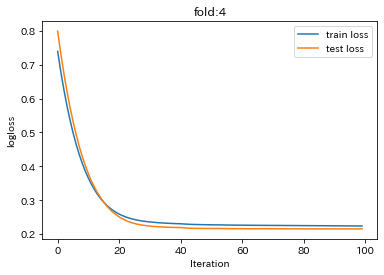

[I 2021-12-14 12:12:48,240] A new study created in memory with name: no-name-99786aba-2343-439d-9e92-58c9dafa68b6


Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:48,605] Trial 0 finished with value: 0.11062713524749547 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.11062713524749547.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119853	Test's rmse: 0.110627
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:48,917] Trial 1 finished with value: 0.11295003048614073 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.11062713524749547.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.120963	Test's rmse: 0.11295
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:49,280] Trial 2 finished with value: 0.10923031483252058 and parameters: {'feature_fraction': 0.8}. Best is trial 2 with value: 0.10923031483252058.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.120391	Test's rmse: 0.10923
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:49,573] Trial 3 finished with value: 0.11436617282716514 and parameters: {'feature_fraction': 0.4}. Best is trial 2 with value: 0.10923031483252058.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.121522	Test's rmse: 0.114366
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:49,947] Trial 4 finished with value: 0.10836537284176956 and parameters: {'feature_fraction': 1.0}. Best is trial 4 with value: 0.10836537284176956.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119899	Test's rmse: 0.108365
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:50,276] Trial 5 finished with value: 0.1107387383859799 and parameters: {'feature_fraction': 0.6}. Best is trial 4 with value: 0.10836537284176956.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.120773	Test's rmse: 0.110739
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:50,612] Trial 6 finished with value: 0.11288479607126256 and parameters: {'feature_fraction': 0.7}. Best is trial 4 with value: 0.10836537284176956.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.120198	Test's rmse: 0.112885
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:51,333] Trial 7 finished with value: 0.11064090871126132 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.11064090871126132.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119711	Test's rmse: 0.110641
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:52,701] Trial 8 finished with value: 0.10907835817708714 and parameters: {'num_leaves': 244}. Best is trial 8 with value: 0.10907835817708714.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119918	Test's rmse: 0.109078
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:53,818] Trial 9 finished with value: 0.1104864025891607 and parameters: {'num_leaves': 188}. Best is trial 8 with value: 0.10907835817708714.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119509	Test's rmse: 0.110486
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:54,806] Trial 10 finished with value: 0.10966351049175349 and parameters: {'num_leaves': 154}. Best is trial 8 with value: 0.10907835817708714.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119861	Test's rmse: 0.109664
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:55,246] Trial 11 finished with value: 0.10845233361511128 and parameters: {'num_leaves': 41}. Best is trial 11 with value: 0.10845233361511128.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.120128	Test's rmse: 0.108452
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:55,690] Trial 12 finished with value: 0.10845233361511128 and parameters: {'num_leaves': 41}. Best is trial 11 with value: 0.10845233361511128.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.120128	Test's rmse: 0.108452
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:55,968] Trial 13 finished with value: 0.11000109583563866 and parameters: {'num_leaves': 16}. Best is trial 11 with value: 0.10845233361511128.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.120092	Test's rmse: 0.110001
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:57,244] Trial 14 finished with value: 0.10946633641999488 and parameters: {'num_leaves': 222}. Best is trial 11 with value: 0.10845233361511128.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119644	Test's rmse: 0.109466
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:58,238] Trial 15 finished with value: 0.10938556156403392 and parameters: {'num_leaves': 155}. Best is trial 11 with value: 0.10845233361511128.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119928	Test's rmse: 0.109386
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:59,323] Trial 16 finished with value: 0.10945196354163261 and parameters: {'num_leaves': 182}. Best is trial 11 with value: 0.10845233361511128.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.11973	Test's rmse: 0.109452
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:12:59,968] Trial 17 finished with value: 0.1085243788344058 and parameters: {'num_leaves': 81}. Best is trial 11 with value: 0.10845233361511128.
[I 2021-12-14 12:13:00,080] Trial 18 finished with value: 0.12499450386701547 and parameters: {'num_leaves': 2}. Best is trial 11 with value: 0.10845233361511128.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.11989	Test's rmse: 0.108524
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132482	Test's rmse: 0.124995
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:00,618] Trial 19 finished with value: 0.10895041379087574 and parameters: {'num_leaves': 56}. Best is trial 11 with value: 0.10845233361511128.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.120193	Test's rmse: 0.10895
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:01,072] Trial 20 finished with value: 0.10845233361511128 and parameters: {'num_leaves': 41}. Best is trial 11 with value: 0.10845233361511128.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.120128	Test's rmse: 0.108452
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:01,813] Trial 21 finished with value: 0.10887717359165289 and parameters: {'num_leaves': 103}. Best is trial 11 with value: 0.10845233361511128.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119905	Test's rmse: 0.108877
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:02,289] Trial 22 finished with value: 0.10858734763886667 and parameters: {'num_leaves': 46}. Best is trial 11 with value: 0.10845233361511128.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.120244	Test's rmse: 0.108587
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:02,874] Trial 23 finished with value: 0.10924361041574876 and parameters: {'num_leaves': 67}. Best is trial 11 with value: 0.10845233361511128.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119931	Test's rmse: 0.109244
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:03,661] Trial 24 finished with value: 0.1093466867570444 and parameters: {'num_leaves': 112}. Best is trial 11 with value: 0.10845233361511128.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.120068	Test's rmse: 0.109347
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:04,011] Trial 25 finished with value: 0.10913510212960979 and parameters: {'num_leaves': 26}. Best is trial 11 with value: 0.10845233361511128.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119901	Test's rmse: 0.109135
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:04,912] Trial 26 finished with value: 0.10949546141126174 and parameters: {'num_leaves': 131}. Best is trial 11 with value: 0.10845233361511128.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119619	Test's rmse: 0.109495
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:05,386] Trial 27 finished with value: 0.1787193755907502 and parameters: {'bagging_fraction': 0.624724071308792, 'bagging_freq': 7}. Best is trial 27 with value: 0.1787193755907502.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.149482	Test's rmse: 0.178719
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:05,862] Trial 28 finished with value: 0.1607825801058813 and parameters: {'bagging_fraction': 0.8391963650875751, 'bagging_freq': 5}. Best is trial 28 with value: 0.1607825801058813.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.1299	Test's rmse: 0.160783
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:06,320] Trial 29 finished with value: 0.20118012304012337 and parameters: {'bagging_fraction': 0.49361118426561795, 'bagging_freq': 2}. Best is trial 28 with value: 0.1607825801058813.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.173047	Test's rmse: 0.20118
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:06,780] Trial 30 finished with value: 0.21803967846472463 and parameters: {'bagging_fraction': 0.4348501673009778, 'bagging_freq': 7}. Best is trial 28 with value: 0.1607825801058813.


Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.184899	Test's rmse: 0.21804
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:07,247] Trial 31 finished with value: 0.16111602169468814 and parameters: {'bagging_fraction': 0.7606690070465265, 'bagging_freq': 5}. Best is trial 28 with value: 0.1607825801058813.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135615	Test's rmse: 0.161116
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:07,700] Trial 32 finished with value: 0.22481004185749903 and parameters: {'bagging_fraction': 0.41235069657750206, 'bagging_freq': 7}. Best is trial 28 with value: 0.1607825801058813.


Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.188641	Test's rmse: 0.22481
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:08,199] Trial 33 finished with value: 0.13379421248739226 and parameters: {'bagging_fraction': 0.8994655844810855, 'bagging_freq': 2}. Best is trial 33 with value: 0.13379421248739226.


Did not meet early stopping. Best iteration is:
[94]	Train's rmse: 0.126058	Test's rmse: 0.133794
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:08,658] Trial 34 finished with value: 0.20256896949264305 and parameters: {'bagging_fraction': 0.5090949803244422, 'bagging_freq': 2}. Best is trial 33 with value: 0.13379421248739226.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172456	Test's rmse: 0.202569
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:09,116] Trial 35 finished with value: 0.1851069996525503 and parameters: {'bagging_fraction': 0.5825453457760269, 'bagging_freq': 4}. Best is trial 33 with value: 0.13379421248739226.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.164407	Test's rmse: 0.185107
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:09,558] Trial 36 finished with value: 0.17904438939270942 and parameters: {'bagging_fraction': 0.6591670111857015, 'bagging_freq': 3}. Best is trial 33 with value: 0.13379421248739226.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144857	Test's rmse: 0.179044
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:09,927] Trial 37 finished with value: 0.11062713524749547 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 37 with value: 0.11062713524749547.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119853	Test's rmse: 0.110627
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:10,292] Trial 38 finished with value: 0.11062713524749547 and parameters: {'feature_fraction': 0.92}. Best is trial 37 with value: 0.11062713524749547.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119853	Test's rmse: 0.110627
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:10,654] Trial 39 finished with value: 0.11062713524749547 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 37 with value: 0.11062713524749547.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119853	Test's rmse: 0.110627
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:11,049] Trial 40 finished with value: 0.11075938997750051 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403}. Best is trial 40 with value: 0.11075938997750051.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.121443	Test's rmse: 0.110759
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:11,420] Trial 41 finished with value: 0.11041777816111051 and parameters: {'lambda_l1': 0.038720902953704193, 'lambda_l2': 0.0024430162614261413}. Best is trial 41 with value: 0.11041777816111051.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119872	Test's rmse: 0.110418
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:11,803] Trial 42 finished with value: 0.10836537319991764 and parameters: {'lambda_l1': 2.5361081166471375e-07, 'lambda_l2': 2.5348407664333426e-07}. Best is trial 42 with value: 0.10836537319991764.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119899	Test's rmse: 0.108365
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:12,192] Trial 43 finished with value: 0.10902386546850693 and parameters: {'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893}. Best is trial 42 with value: 0.10836537319991764.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119841	Test's rmse: 0.109024
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:12,573] Trial 44 finished with value: 0.10886990252250812 and parameters: {'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682}. Best is trial 42 with value: 0.10836537319991764.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.11977	Test's rmse: 0.10887
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:12,967] Trial 45 finished with value: 0.11079247011210834 and parameters: {'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285}. Best is trial 42 with value: 0.10836537319991764.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.121373	Test's rmse: 0.110792
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:13,286] Trial 46 finished with value: 0.11151862997377805 and parameters: {'lambda_l1': 0.31044435499483225, 'lambda_l2': 8.148018307012941e-07}. Best is trial 42 with value: 0.10836537319991764.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119726	Test's rmse: 0.111519
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:13,654] Trial 47 finished with value: 0.10836537334275193 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07}. Best is trial 42 with value: 0.10836537319991764.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119899	Test's rmse: 0.108365
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:14,044] Trial 48 finished with value: 0.10870443185086161 and parameters: {'lambda_l1': 5.472429642032198e-06, 'lambda_l2': 0.00052821153945323}. Best is trial 42 with value: 0.10836537319991764.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119693	Test's rmse: 0.108704
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:14,428] Trial 49 finished with value: 0.10879924120737158 and parameters: {'lambda_l1': 7.71800699380605e-05, 'lambda_l2': 4.17890272377219e-06}. Best is trial 42 with value: 0.10836537319991764.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119645	Test's rmse: 0.108799
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:14,669] Trial 50 finished with value: 0.11303003851443157 and parameters: {'lambda_l1': 3.207959657544482, 'lambda_l2': 1.1323342574941946e-08}. Best is trial 42 with value: 0.10836537319991764.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.122627	Test's rmse: 0.11303
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:15,060] Trial 51 finished with value: 0.10836537449661304 and parameters: {'lambda_l1': 8.739208840790941e-07, 'lambda_l2': 1.99371629285331e-06}. Best is trial 42 with value: 0.10836537319991764.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119899	Test's rmse: 0.108365
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:15,449] Trial 52 finished with value: 0.10836537304309803 and parameters: {'lambda_l1': 3.2956792945849545e-07, 'lambda_l2': 2.2311398834761413e-08}. Best is trial 52 with value: 0.10836537304309803.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119899	Test's rmse: 0.108365
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:15,841] Trial 53 finished with value: 0.10900785593719893 and parameters: {'lambda_l1': 0.0008421907750901968, 'lambda_l2': 1.2702524155028834e-08}. Best is trial 52 with value: 0.10836537304309803.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.120231	Test's rmse: 0.109008
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:16,227] Trial 54 finished with value: 0.10836538581356828 and parameters: {'lambda_l1': 3.447615183683311e-07, 'lambda_l2': 2.6087844118276602e-05}. Best is trial 52 with value: 0.10836537304309803.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119899	Test's rmse: 0.108365
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:16,604] Trial 55 finished with value: 0.10836537679288215 and parameters: {'lambda_l1': 4.895525573655169e-06, 'lambda_l2': 1.3153049473274364e-07}. Best is trial 52 with value: 0.10836537304309803.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119899	Test's rmse: 0.108365
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:16,991] Trial 56 finished with value: 0.10836539021691152 and parameters: {'lambda_l1': 8.888685965689552e-08, 'lambda_l2': 3.59424753355417e-05}. Best is trial 52 with value: 0.10836537304309803.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119899	Test's rmse: 0.108365
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:17,375] Trial 57 finished with value: 0.10906227367916153 and parameters: {'lambda_l1': 0.00013207817698280088, 'lambda_l2': 6.182028633393764e-08}. Best is trial 52 with value: 0.10836537304309803.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.11997	Test's rmse: 0.109062
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:17,763] Trial 58 finished with value: 0.10870423169876307 and parameters: {'lambda_l1': 4.976594151195463e-06, 'lambda_l2': 7.918734875085908e-05}. Best is trial 52 with value: 0.10836537304309803.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119693	Test's rmse: 0.108704
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:18,157] Trial 59 finished with value: 0.108538155253421 and parameters: {'lambda_l1': 0.0057550268638067925, 'lambda_l2': 8.059918212278755e-08}. Best is trial 52 with value: 0.10836537304309803.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119757	Test's rmse: 0.108538
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:18,574] Trial 60 finished with value: 0.3087236275460268 and parameters: {'min_child_samples': 100}. Best is trial 60 with value: 0.3087236275460268.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.253977	Test's rmse: 0.308724
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:18,969] Trial 61 finished with value: 0.17036349629901537 and parameters: {'min_child_samples': 25}. Best is trial 61 with value: 0.17036349629901537.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133303	Test's rmse: 0.170363
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:19,328] Trial 62 finished with value: 0.06261029543620436 and parameters: {'min_child_samples': 10}. Best is trial 62 with value: 0.06261029543620436.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0730358	Test's rmse: 0.0626103
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:19,634] Trial 63 finished with value: 0.03463908756503014 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.03463908756503014.


Early stopping, best iteration is:
[41]	Train's rmse: 0.0524245	Test's rmse: 0.0346391
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:20,033] Trial 64 finished with value: 0.24052541114732584 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.03463908756503014.


Early stopping, best iteration is:
[49]	Train's rmse: 0.208333	Test's rmse: 0.240525


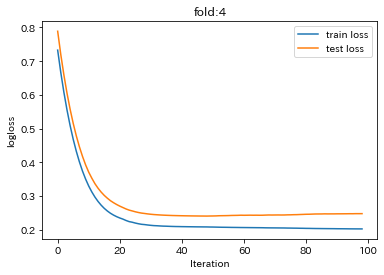

[I 2021-12-14 12:13:20,224] A new study created in memory with name: no-name-5f97d34f-28aa-47d6-a0d1-85adb70a0a4d


Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:20,519] Trial 0 finished with value: 0.22890429630380113 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.22890429630380113.


Early stopping, best iteration is:
[45]	Train's rmse: 0.10416	Test's rmse: 0.228904
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:20,829] Trial 1 finished with value: 0.22892449373968266 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.22890429630380113.


Early stopping, best iteration is:
[45]	Train's rmse: 0.10374	Test's rmse: 0.228924
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:21,183] Trial 2 finished with value: 0.22859300651120093 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 2 with value: 0.22859300651120093.


Early stopping, best iteration is:
[46]	Train's rmse: 0.102078	Test's rmse: 0.228593
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:21,473] Trial 3 finished with value: 0.22973119822717084 and parameters: {'feature_fraction': 0.6}. Best is trial 2 with value: 0.22859300651120093.


Early stopping, best iteration is:
[45]	Train's rmse: 0.104205	Test's rmse: 0.229731
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:21,819] Trial 4 finished with value: 0.22920891162849005 and parameters: {'feature_fraction': 1.0}. Best is trial 2 with value: 0.22859300651120093.


Early stopping, best iteration is:
[44]	Train's rmse: 0.102601	Test's rmse: 0.229209
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:22,160] Trial 5 finished with value: 0.2287679089774151 and parameters: {'feature_fraction': 0.8}. Best is trial 2 with value: 0.22859300651120093.


Early stopping, best iteration is:
[48]	Train's rmse: 0.102174	Test's rmse: 0.228768
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:22,452] Trial 6 finished with value: 0.23286136875146357 and parameters: {'feature_fraction': 0.4}. Best is trial 2 with value: 0.22859300651120093.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0976384	Test's rmse: 0.232861
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:23,078] Trial 7 finished with value: 0.2286993529443253 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.2286993529443253.


Early stopping, best iteration is:
[45]	Train's rmse: 0.102324	Test's rmse: 0.228699
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:24,194] Trial 8 finished with value: 0.22884439124741868 and parameters: {'num_leaves': 244}. Best is trial 7 with value: 0.2286993529443253.


Early stopping, best iteration is:
[44]	Train's rmse: 0.102691	Test's rmse: 0.228844
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:25,097] Trial 9 finished with value: 0.22884470811667207 and parameters: {'num_leaves': 188}. Best is trial 7 with value: 0.2286993529443253.


Early stopping, best iteration is:
[44]	Train's rmse: 0.102692	Test's rmse: 0.228845
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:25,860] Trial 10 finished with value: 0.22884457897370522 and parameters: {'num_leaves': 154}. Best is trial 7 with value: 0.2286993529443253.


Early stopping, best iteration is:
[44]	Train's rmse: 0.102692	Test's rmse: 0.228845
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:26,285] Trial 11 finished with value: 0.2294263975227196 and parameters: {'num_leaves': 41}. Best is trial 7 with value: 0.2286993529443253.


Early stopping, best iteration is:
[49]	Train's rmse: 0.101483	Test's rmse: 0.229426
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:26,714] Trial 12 finished with value: 0.2294263975227196 and parameters: {'num_leaves': 41}. Best is trial 7 with value: 0.2286993529443253.


Early stopping, best iteration is:
[49]	Train's rmse: 0.101483	Test's rmse: 0.229426
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:26,967] Trial 13 finished with value: 0.22854994443229862 and parameters: {'num_leaves': 16}. Best is trial 13 with value: 0.22854994443229862.


Early stopping, best iteration is:
[46]	Train's rmse: 0.102105	Test's rmse: 0.22855
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:27,995] Trial 14 finished with value: 0.2288444009514304 and parameters: {'num_leaves': 222}. Best is trial 13 with value: 0.22854994443229862.


Early stopping, best iteration is:
[44]	Train's rmse: 0.102691	Test's rmse: 0.228844
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:28,791] Trial 15 finished with value: 0.22884457291462793 and parameters: {'num_leaves': 155}. Best is trial 13 with value: 0.22854994443229862.


Early stopping, best iteration is:
[44]	Train's rmse: 0.102692	Test's rmse: 0.228845
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:29,682] Trial 16 finished with value: 0.22884473399991054 and parameters: {'num_leaves': 182}. Best is trial 13 with value: 0.22854994443229862.


Early stopping, best iteration is:
[44]	Train's rmse: 0.102692	Test's rmse: 0.228845
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:29,870] Trial 17 finished with value: 0.23236064883636542 and parameters: {'num_leaves': 7}. Best is trial 13 with value: 0.22854994443229862.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0975532	Test's rmse: 0.232361
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:30,445] Trial 18 finished with value: 0.22869958558027126 and parameters: {'num_leaves': 82}. Best is trial 13 with value: 0.22854994443229862.


Early stopping, best iteration is:
[45]	Train's rmse: 0.102301	Test's rmse: 0.2287
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:31,099] Trial 19 finished with value: 0.22896825103481566 and parameters: {'num_leaves': 109}. Best is trial 13 with value: 0.22854994443229862.


Early stopping, best iteration is:
[44]	Train's rmse: 0.102554	Test's rmse: 0.228968
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:31,677] Trial 20 finished with value: 0.22871378300150833 and parameters: {'num_leaves': 86}. Best is trial 13 with value: 0.22854994443229862.


Early stopping, best iteration is:
[45]	Train's rmse: 0.102313	Test's rmse: 0.228714
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:31,880] Trial 21 finished with value: 0.22940587915797422 and parameters: {'num_leaves': 10}. Best is trial 13 with value: 0.22854994443229862.


Early stopping, best iteration is:
[43]	Train's rmse: 0.103818	Test's rmse: 0.229406
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:32,335] Trial 22 finished with value: 0.229843660125245 and parameters: {'num_leaves': 62}. Best is trial 13 with value: 0.22854994443229862.


Early stopping, best iteration is:
[40]	Train's rmse: 0.103777	Test's rmse: 0.229844
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:32,997] Trial 23 finished with value: 0.22896825103481566 and parameters: {'num_leaves': 109}. Best is trial 13 with value: 0.22854994443229862.


Early stopping, best iteration is:
[44]	Train's rmse: 0.102554	Test's rmse: 0.228968
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:33,383] Trial 24 finished with value: 0.22932223359305814 and parameters: {'num_leaves': 35}. Best is trial 13 with value: 0.22854994443229862.


Early stopping, best iteration is:
[49]	Train's rmse: 0.101331	Test's rmse: 0.229322
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:34,126] Trial 25 finished with value: 0.22918543270140718 and parameters: {'num_leaves': 128}. Best is trial 13 with value: 0.22854994443229862.


Early stopping, best iteration is:
[46]	Train's rmse: 0.10229	Test's rmse: 0.229185
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:34,620] Trial 26 finished with value: 0.228708515622166 and parameters: {'num_leaves': 65}. Best is trial 13 with value: 0.22854994443229862.


Early stopping, best iteration is:
[45]	Train's rmse: 0.102322	Test's rmse: 0.228709
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:34,953] Trial 27 finished with value: 0.2779719502333258 and parameters: {'bagging_fraction': 0.624724071308792, 'bagging_freq': 7}. Best is trial 27 with value: 0.2779719502333258.


Did not meet early stopping. Best iteration is:
[89]	Train's rmse: 0.143085	Test's rmse: 0.277972
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:35,293] Trial 28 finished with value: 0.238833854531983 and parameters: {'bagging_fraction': 0.8391963650875751, 'bagging_freq': 5}. Best is trial 28 with value: 0.238833854531983.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.110425	Test's rmse: 0.238834
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:35,616] Trial 29 finished with value: 0.2864592312854203 and parameters: {'bagging_fraction': 0.49361118426561795, 'bagging_freq': 2}. Best is trial 28 with value: 0.238833854531983.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.151475	Test's rmse: 0.286459
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:35,938] Trial 30 finished with value: 0.29769305108182414 and parameters: {'bagging_fraction': 0.4348501673009778, 'bagging_freq': 7}. Best is trial 28 with value: 0.238833854531983.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.169783	Test's rmse: 0.297693
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:36,267] Trial 31 finished with value: 0.23872515461780883 and parameters: {'bagging_fraction': 0.7606690070465265, 'bagging_freq': 5}. Best is trial 31 with value: 0.23872515461780883.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.11096	Test's rmse: 0.238725
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:36,600] Trial 32 finished with value: 0.2982040716199606 and parameters: {'bagging_fraction': 0.41235069657750206, 'bagging_freq': 7}. Best is trial 31 with value: 0.23872515461780883.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.177299	Test's rmse: 0.298204
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:36,941] Trial 33 finished with value: 0.23667639174621805 and parameters: {'bagging_fraction': 0.8994655844810855, 'bagging_freq': 2}. Best is trial 33 with value: 0.23667639174621805.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.104369	Test's rmse: 0.236676
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:37,263] Trial 34 finished with value: 0.28648540031100406 and parameters: {'bagging_fraction': 0.5090949803244422, 'bagging_freq': 2}. Best is trial 33 with value: 0.23667639174621805.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147981	Test's rmse: 0.286485
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:37,584] Trial 35 finished with value: 0.28014612917324144 and parameters: {'bagging_fraction': 0.5825453457760269, 'bagging_freq': 4}. Best is trial 33 with value: 0.23667639174621805.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140572	Test's rmse: 0.280146
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:37,914] Trial 36 finished with value: 0.2611814791515555 and parameters: {'bagging_fraction': 0.6591670111857015, 'bagging_freq': 3}. Best is trial 33 with value: 0.23667639174621805.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.126962	Test's rmse: 0.261181
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:38,165] Trial 37 finished with value: 0.22845441571450187 and parameters: {'feature_fraction': 0.8839999999999999}. Best is trial 37 with value: 0.22845441571450187.


Early stopping, best iteration is:
[46]	Train's rmse: 0.102263	Test's rmse: 0.228454
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:38,427] Trial 38 finished with value: 0.22845441571450187 and parameters: {'feature_fraction': 0.82}. Best is trial 37 with value: 0.22845441571450187.


Early stopping, best iteration is:
[46]	Train's rmse: 0.102263	Test's rmse: 0.228454
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:38,682] Trial 39 finished with value: 0.22845441571450187 and parameters: {'feature_fraction': 0.852}. Best is trial 37 with value: 0.22845441571450187.


Early stopping, best iteration is:
[46]	Train's rmse: 0.102263	Test's rmse: 0.228454
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:38,941] Trial 40 finished with value: 0.22854994443229862 and parameters: {'feature_fraction': 0.948}. Best is trial 37 with value: 0.22845441571450187.


Early stopping, best iteration is:
[46]	Train's rmse: 0.102105	Test's rmse: 0.22855
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:39,199] Trial 41 finished with value: 0.22854994443229862 and parameters: {'feature_fraction': 0.9159999999999999}. Best is trial 37 with value: 0.22845441571450187.


Early stopping, best iteration is:
[46]	Train's rmse: 0.102105	Test's rmse: 0.22855
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:39,467] Trial 42 finished with value: 0.22854994443229862 and parameters: {'feature_fraction': 0.9799999999999999}. Best is trial 37 with value: 0.22845441571450187.


Early stopping, best iteration is:
[46]	Train's rmse: 0.102105	Test's rmse: 0.22855
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:39,750] Trial 43 finished with value: 0.23171693089057974 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403}. Best is trial 43 with value: 0.23171693089057974.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0965253	Test's rmse: 0.231717
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:40,014] Trial 44 finished with value: 0.22922921235058935 and parameters: {'lambda_l1': 0.038720902953704193, 'lambda_l2': 0.0024430162614261413}. Best is trial 44 with value: 0.22922921235058935.


Early stopping, best iteration is:
[49]	Train's rmse: 0.101856	Test's rmse: 0.229229
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:40,270] Trial 45 finished with value: 0.22845441599728816 and parameters: {'lambda_l1': 2.5361081166471375e-07, 'lambda_l2': 2.5348407664333426e-07}. Best is trial 45 with value: 0.22845441599728816.


Early stopping, best iteration is:
[46]	Train's rmse: 0.102263	Test's rmse: 0.228454
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:40,537] Trial 46 finished with value: 0.2293416058688638 and parameters: {'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893}. Best is trial 45 with value: 0.22845441599728816.


Early stopping, best iteration is:
[48]	Train's rmse: 0.102438	Test's rmse: 0.229342
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:40,789] Trial 47 finished with value: 0.2284561020161026 and parameters: {'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682}. Best is trial 45 with value: 0.22845441599728816.


Early stopping, best iteration is:
[46]	Train's rmse: 0.102059	Test's rmse: 0.228456
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:41,065] Trial 48 finished with value: 0.23180163935254505 and parameters: {'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285}. Best is trial 45 with value: 0.22845441599728816.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0986543	Test's rmse: 0.231802
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:41,323] Trial 49 finished with value: 0.2293543793754877 and parameters: {'lambda_l1': 0.31044435499483225, 'lambda_l2': 8.148018307012941e-07}. Best is trial 45 with value: 0.22845441599728816.


Early stopping, best iteration is:
[48]	Train's rmse: 0.102252	Test's rmse: 0.229354
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:41,581] Trial 50 finished with value: 0.22845441617608692 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07}. Best is trial 45 with value: 0.22845441599728816.


Early stopping, best iteration is:
[46]	Train's rmse: 0.102263	Test's rmse: 0.228454
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:41,832] Trial 51 finished with value: 0.228454677548191 and parameters: {'lambda_l1': 5.472429642032198e-06, 'lambda_l2': 0.00052821153945323}. Best is trial 45 with value: 0.22845441599728816.


Early stopping, best iteration is:
[46]	Train's rmse: 0.102263	Test's rmse: 0.228455
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:42,080] Trial 52 finished with value: 0.22845445995885671 and parameters: {'lambda_l1': 7.71800699380605e-05, 'lambda_l2': 4.17890272377219e-06}. Best is trial 45 with value: 0.22845441599728816.


Early stopping, best iteration is:
[46]	Train's rmse: 0.102263	Test's rmse: 0.228454
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:42,298] Trial 53 finished with value: 0.23641345528365418 and parameters: {'lambda_l1': 3.207959657544482, 'lambda_l2': 1.1323342574941946e-08}. Best is trial 45 with value: 0.22845441599728816.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.101394	Test's rmse: 0.236413
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:42,553] Trial 54 finished with value: 0.2284544170744317 and parameters: {'lambda_l1': 8.739208840790941e-07, 'lambda_l2': 1.99371629285331e-06}. Best is trial 45 with value: 0.22845441599728816.


Early stopping, best iteration is:
[46]	Train's rmse: 0.102263	Test's rmse: 0.228454
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:42,803] Trial 55 finished with value: 0.22845441595574062 and parameters: {'lambda_l1': 3.2956792945849545e-07, 'lambda_l2': 2.2311398834761413e-08}. Best is trial 55 with value: 0.22845441595574062.


Early stopping, best iteration is:
[46]	Train's rmse: 0.102263	Test's rmse: 0.228454
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:43,058] Trial 56 finished with value: 0.2284543463059313 and parameters: {'lambda_l1': 0.0008421907750901968, 'lambda_l2': 1.2702524155028834e-08}. Best is trial 56 with value: 0.2284543463059313.


Early stopping, best iteration is:
[46]	Train's rmse: 0.102263	Test's rmse: 0.228454
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:43,316] Trial 57 finished with value: 0.22845425489156085 and parameters: {'lambda_l1': 0.0013643656722816411, 'lambda_l2': 1.079490244377404e-08}. Best is trial 57 with value: 0.22845425489156085.


Early stopping, best iteration is:
[46]	Train's rmse: 0.102264	Test's rmse: 0.228454
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:43,575] Trial 58 finished with value: 0.22845620577395578 and parameters: {'lambda_l1': 0.003023160733725813, 'lambda_l2': 2.2881943301070796e-05}. Best is trial 57 with value: 0.22845425489156085.


Early stopping, best iteration is:
[46]	Train's rmse: 0.102265	Test's rmse: 0.228456
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:43,825] Trial 59 finished with value: 0.2284543737795931 and parameters: {'lambda_l1': 0.0011583005335620482, 'lambda_l2': 3.895011696762577e-05}. Best is trial 57 with value: 0.22845425489156085.


Early stopping, best iteration is:
[46]	Train's rmse: 0.102264	Test's rmse: 0.228454
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:44,081] Trial 60 finished with value: 0.2285262238772627 and parameters: {'lambda_l1': 0.03279298313076472, 'lambda_l2': 5.638381896970737e-08}. Best is trial 57 with value: 0.22845425489156085.


Early stopping, best iteration is:
[46]	Train's rmse: 0.102238	Test's rmse: 0.228526
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:44,331] Trial 61 finished with value: 0.22845463456425957 and parameters: {'lambda_l1': 0.0004000642832347162, 'lambda_l2': 9.176423048893653e-08}. Best is trial 57 with value: 0.22845425489156085.


Early stopping, best iteration is:
[46]	Train's rmse: 0.102263	Test's rmse: 0.228455
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:44,586] Trial 62 finished with value: 0.228584852066241 and parameters: {'lambda_l1': 0.012916956058769335, 'lambda_l2': 2.890065127190206e-05}. Best is trial 57 with value: 0.22845425489156085.


Early stopping, best iteration is:
[45]	Train's rmse: 0.102346	Test's rmse: 0.228585
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:44,881] Trial 63 finished with value: 0.3629468453850555 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.3629468453850555.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.236063	Test's rmse: 0.362947
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:45,115] Trial 64 finished with value: 0.16175086604315964 and parameters: {'min_child_samples': 10}. Best is trial 64 with value: 0.16175086604315964.


Early stopping, best iteration is:
[45]	Train's rmse: 0.055376	Test's rmse: 0.161751
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:45,399] Trial 65 finished with value: 0.31487913081688784 and parameters: {'min_child_samples': 50}. Best is trial 64 with value: 0.16175086604315964.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.178446	Test's rmse: 0.314879
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:45,667] Trial 66 finished with value: 0.27390740466731495 and parameters: {'min_child_samples': 25}. Best is trial 64 with value: 0.16175086604315964.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132361	Test's rmse: 0.273907
Training until validation scores don't improve for 50 rounds.


[I 2021-12-14 12:13:45,902] Trial 67 finished with value: 0.11998871989525714 and parameters: {'min_child_samples': 5}. Best is trial 67 with value: 0.11998871989525714.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0118842	Test's rmse: 0.119989


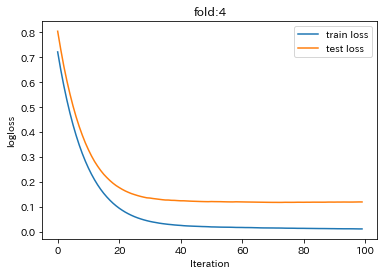

RMSE: [0.05267933998492862, 0.010997591531314964, 0.03207141692427357, 0.0346390808186331, 0.1199887329911365]
RMSE: 0.05007523245005735


In [ ]:
# 学習・推論
gkf = GroupKFold(n_splits=5)

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': 'rmse',             # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'deterministic':True,         # 再現性確保用のパラメータ
          'force_row_wise':True,        # 再現性確保用のパラメータ
          'seed': SEED                  # シード値
          }

groups = pred_df[best_model_name]

cv_result_stck_lgbm = []

for train_index, test_index in gkf.split(pred_df, y_train_dropna, groups):

    X_train_gkf, X_test_gkf = pred_df.iloc[train_index], pred_df.iloc[test_index]
    y_train_gkf, y_test_gkf = y_train_dropna.iloc[train_index], y_train_dropna.iloc[test_index]

    # 学習、推論
    lgb_train = opt_lgb.Dataset(X_train_gkf, y_train_gkf)
    lgb_test = opt_lgb.Dataset(X_test_gkf, y_test_gkf, reference=lgb_train)

    model = opt_lgb.LightGBMTuner(
                    params,                    # ハイパーパラメータをセット
                    lgb_train,              # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=100,              # 計算回数
                    early_stopping_rounds=50,         # アーリーストッピング設定
                    evals_result=lgb_results,
                    verbose_eval=-1,                  # ログを最後の1つだけ表示
                    show_progress_bar = False,        # ログの非表示
                    optuna_seed=SEED,
                    )
    
    # 訓練の実施
    model.run()
    
    best_params = model.best_params
    

   # 損失推移を表示
    loss_train = lgb_results['Train']['rmse']
    loss_test = lgb_results['Test']['rmse']   
    
    fig = plt.figure()
    
    plt.xlabel('Iteration')
    plt.ylabel('logloss')

    plt.title(f"fold:{fold}")
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='test loss')
    
    plt.legend()
    plt.show()

    # 推論
    best_model = model.get_best_booster()

    y_pred = best_model.predict(X_test_gkf)

    # 評価
    rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)
    cv_result_stck_lgbm.append(rmse)

print("RMSE:", cv_result_stck_lgbm)
print("RMSE:", np.mean(cv_result_stck_lgbm))

In [ ]:
print("RMSE:", round(np.mean(cv_result), 4))
print(f"Best Model {best_model_name} Stacking RMSE:", round(np.mean(cv_result_stck_best_model), 4))
print("Optuna LightGBM Stacking RMSE:", round(np.mean(cv_result_stck_lgbm), 4))

RMSE: 0.1799
Best Model xgboost Stacking RMSE: 0.066
Optuna LightGBM Stacking RMSE: 0.0501
